# Project Background

## Business Problem
The business refers to the collective facilities and terminals that conduct maritime trade, and which handle country's harbours and shipping.

As a result of country being predominantly a transhipment port, it is highly sensitive to seasonal product trends in different countries as well as frequent unplanned changes to arrival times for incoming and outgoing ships. 
The company is looking for a solution that can analyze containers transhipment information, port congestion and identify patterns that can be used to improve planning around: \
I. Potential delays in berthing  \
II. Duration of vessel stay \
III. Number of incoming container


## Business Objective
- Identify the trends and predict the changes of vessel arrival and departure to optimize ground processes during congestion and seasonal spikes.

- Identify the features that contribute to better visibility of incoming vessel and container in time series.

- Identify seasonal trends by region / country and forecast surges in port call, berth and unberth request, container movement based on time series to aid in the agile deployment of resources

- Identify features that contribute to berth time, vessel dwell and container dwell.


## Analytics Objective

- Identify the trends and predict the changes of vessel berth and unberth.

- Analyse the features in time series and it's correlation with target label.

- Identify and prioritize the features in particular.

- Identify seasonal trends by region / country and forecast on demand surge.

- Identify and analyze the features that contribute to berth time, vessel dwell and container dwell.

## Table of contents

* [0. Initial Setup](#0.InitialSetup)

* [1. Reading Data](#1.ReadingData)

* [2. Features Engineering](#2.FeaturesEngineering)

* [3. Data Cleaning and Initial Processing](#3.DataCleaningandInitialProcessing)

* [4. EDA](#4.EDA)

* [5. Machine Learning Model](#5.MachineLearningModel)  

* [6. Lift Chart for vessel dwell](#6.LiftChartforvesseldwell)  

* [7. Lift Chart for container dwell](#7.LiftChartforcontainerdwell)  

## 0. Initial Setup <a class="anchor" id="0.InitialSetup"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
%matplotlib inline

from itertools import product

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

sns.set(rc={'figure.figsize':(11,4)})

#Machine learning packages
import statistics
import math
import sklearn.metrics as sklm
import statsmodels.api as sm
import scikitplot as skplt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from scipy.stats import uniform, truncnorm, randint
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split, ParameterGrid

from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from mlxtend.evaluate import lift_score

## 1. Reading Data <a class="anchor" id="1.ReadingData"></a>

In [2]:
df = pd.read_csv("sample_1mil.csv") 
ports = pd.read_csv('country_codes.csv')

In [3]:
df

EVENT_C CNTR_STATUS_C DISC_PORT1_C LOAD_PORT_C ABBR_VESSEL_M1  \
0         DISC             F        MYWSP       FRFOS         V12095   
1         LOAD             E        IDUTE       KHKOS         V11038   
2         DISC             F          NaN       MYPKG         V11329   
3         LOAD             F        CAVA3       INKTP         V11516   
4         DISC             F          NaN       CNCWN         V11594   
...        ...           ...          ...         ...            ...   
999995    DISC             F        JOAQJ       IDSRG         V12193   
999996    DISC             F        USCHS       THLCH         V12854   
999997    DISC             F        USCHS       MYPGU         V12165   
999998    DISC             F        PKKHI       THLCH         V12279   
999999    LOAD             F        TWKEL       INNSA         V12224   

                       BTR1                 ATD1                 ATU1  \
0        2019/10/04 1:08:00   2019/10/04 5:38:00   2019/10/05 9:35:00   
1        2018/02/05 2:40:00   2018/02/05 3:35:00  2018/02/05 19:35:00   
2        2018/03/21 1:42:00   2018/03/21 2:32:00  2018/03/21 22:22:00   
3        2018/09/18 0:04:00   2018/09/18 1:26:00   2018/09/19 5:08:00   
4       2017/01/15 17:30:00  2017/01/15 18:50:00  2017/01/16 13:52:00   
...                     ...                  ...                  ...   
999995  2017/12/29 23:01:00   2017/12/30 6:25:00  2017/12/30 19:35:00   
999996  2019/10/10 13:20:00  2019/10/10 15:50:00   2019/10/11 7:57:00   
999997   2017/01/02 9:04:00   2017/01/02 9:24:00  2017/01/02 18:49:00   
999998  2018/03/25 17:50:00  2018/03/25 18:20:00  2018/03/26 12:32:00   
999999   2018/02/19 5:08:00   2018/02/19 4:53:00   2018/02/20 8:15:00   

       LINE_C1_GROUP SERVICE_C1 SERVICE_TYPE_DESC_X1 DIRECTION_C1  \
0               L346      S7454    EFE/MEDITTERANEAN            E   
1               L389      S7400           INTRA-ASIA            E   
2               L341      S7306  INTRA-ASIA EXTENDED            E   
3               L367      S7462        TRANS-PACIFIC            E   
4               L348      S7528    EFE/MEDITTERANEAN            N   
...              ...        ...                  ...          ...   
999995          L402      S7330                  NaN            S   
999996          L390      S7440               EU/ANZ            W   
999997          L380      S7539        COMMON FEEDER            E   
999998          L344      S7309                  NaN            W   
999999          L390      S7430                  NaN            W   

       CONSORTIUM_C1  CAPACITY_1 ABBR_VESSEL_M2                 BTR2  \
0              C5059     14000.0         V12628  2019/10/07 21:14:00   
1                NaN      5000.0         V10719  2018/01/31 10:02:00   
2              C5192      4000.0            NaN   1900/01/01 0:00:00   
3              C5059      9000.0         V10453  2018/09/15 22:00:00   
4              C5109     14000.0            NaN   1900/01/01 0:00:00   
...              ...         ...            ...                  ...   
999995           NaN       700.0         V11754  2018/01/06 23:12:00   
999996         C5109      7000.0         V10091  2019/10/15 18:30:00   
999997           NaN       300.0         V10266  2017/01/06 18:12:00   
999998         C5066      2000.0         V12253   2018/03/30 9:30:00   
999999           NaN      2000.0         V10476  2018/02/13 17:26:00   

                       ATD2                 ATU2 LINE_C2_GROUP SERVICE_C2  \
0        2019/10/08 4:01:00   2019/10/09 0:18:00          L347      S7597   
1        2018/01/31 9:52:00  2018/02/01 16:52:00          L402      S7414   
2        1900/01/01 0:00:00   1900/01/01 0:00:00           NaN        NaN   
3       2018/09/15 23:30:00  2018/09/16 17:17:00          L391      S7389   
4        1900/01/01 0:00:00   1900/01/01 0:00:00           NaN        NaN   
...                     ...                  ...           ...        ...   
999995   2018/01/07 1:14:00  201

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 28 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   EVENT_C               1000000 non-null  object 
 1   CNTR_STATUS_C         1000000 non-null  object 
 2   DISC_PORT1_C          962403 non-null   object 
 3   LOAD_PORT_C           966358 non-null   object 
 4   ABBR_VESSEL_M1        1000000 non-null  object 
 5   BTR1                  1000000 non-null  object 
 6   ATD1                  1000000 non-null  object 
 7   ATU1                  1000000 non-null  object 
 8   LINE_C1_GROUP         1000000 non-null  object 
 9   SERVICE_C1            1000000 non-null  object 
 10  SERVICE_TYPE_DESC_X1  885482 non-null   object 
 11  DIRECTION_C1          1000000 non-null  object 
 12  CONSORTIUM_C1         749321 non-null   object 
 13  CAPACITY_1            1000000 non-null  float64
 14  ABBR_VESSEL_M2        908482 non-nu

## 2. Features Engineering <a class="anchor" id="2.FeaturesEngineering"></a>

In [5]:
config={       
   
    "TIDY_DATES": ['BTR1','ATD1','ATU1','BTR2','ATD2','ATU2'],  #list of columns to be formatted into datetime data types
    "LAG_COLS": ['SUMOFTEU_Q','SUMOFBOX_Q'], #columns names for which moving average/trend variable has to be created
    "LAG": [2,3,5,7], #size for moving average window
}

In [6]:
def get_tidy_dates(df, config):    
    
    df[config['TIDY_DATES']]=df[config['TIDY_DATES']].apply(pd.to_datetime,format='%Y-%m-%d')
        
    return df  

In [7]:
def get_time_related_features(df):  
    
    """
    Get a dataframe creating all time/seasonality related features on a given date column
    Inputs      : df      = psa dataframe with delay metrics calculated as a column
    outputs     : Updated data frame with all new time/seasonality features created
    """
    
    #time seasionality   
    df['ARRIVAL_DATE'] =df['ATD1'].dt.strftime('%Y-%m-%d')
    df['ARRIVAL_WEEK']=df['ATD1'].dt.strftime('%Y-%U')
    df['ARRIVAL_MONTH']=df['ATD1'].dt.strftime('%Y-%m')
    df['DAY_OF_MONTH']=df['ATD1'].dt.day
    df['WEEK_OF_YEAR']=df['ATD1'].dt.isocalendar().week
    df['MONTH_OF_YEAR']=df['ATD1'].dt.month
    df['QUARTER_OF_YEAR']=df['ATD1'].dt.quarter
    df['YEAR']=df['ATD1'].dt.year
    
    return df

In [8]:
def get_ports_country(df,ports):
    
    """
    Get country of the ports merged with PSA data frame
    Inputs      : df      = psa dataframe
                : ports   = ports dataframe
    outputs     : updated data frame with ports country mapped to psa data frame
    """
    
    df['DISC_PORT1_C_ID'] = df.DISC_PORT1_C.astype(str).str[:2]
    df['LOAD_PORT_ID'] = df.LOAD_PORT_C.astype(str).str[:2]
    
    df=pd.merge(df, ports,left_on='DISC_PORT1_C_ID',right_on='ISO 3166-1',how='left')
    df=pd.merge(df, ports,left_on='LOAD_PORT_ID',right_on='ISO 3166-1',how='left')

    df.rename(columns={'Country Name_x':'DISC_COUNTRY','Country Name_y':'LOAD_COUNTRY'}, inplace=True)
    df=df.drop(['ISO 3166-1_x','ISO 3166-1_y','DISC_PORT1_C_ID','LOAD_PORT_ID'],axis=1)
    
    return df

In [9]:
def get_vessel_type(df):
    
    """
    Get a vessel category type based n capacity i.e. feeder, panamax, etc.
    Inputs      : df      = psa dataframe
    outputs     : updated data frame with vessel type crated
    """
    
    df['VESSEL_TYPE_M1']=np.where((df.CAPACITY_1<=3000),"Feeder",np.where(((df.CAPACITY_1>3000)&(df.CAPACITY_1<=8000)),"Intermediate",np.where(((df.CAPACITY_1>8000)&(df.CAPACITY_1<=15000)),"Neo-Panamax","Post-Panamax")))
    df['VESSEL_TYPE_M2']=np.where((df.CAPACITY_2<=3000),"Feeder",np.where(((df.CAPACITY_2>3000)&(df.CAPACITY_2<=8000)),"Intermediate",np.where(((df.CAPACITY_2>8000)&(df.CAPACITY_2<=15000)),"Neo-Panamax","Post-Panamax")))
    
    df['CONTAINER_LOAD_VESSEL_TYPE']=np.where(df.EVENT_C=="LOAD",df.VESSEL_TYPE_M1,df.VESSEL_TYPE_M2)
    
    return df

In [10]:
def get_lag_variables(df, config):
    
    """
    Get a dataframe summarizing container delays
    Inputs      : df                 = psa dataframe
                : config['LAG_COLS'] = list of columns specified in config for which lag and trend(moving average) variables has to be created
                : config['LAG'] = window of moving average i.e., 3 days/7 days moving average to be specified in config
    outputs     : updated data frame summarizing container delays
    """
    for col,lag  in product(config['LAG_COLS'],config['LAG']):
        df[col+'_'+str(lag)] = df[col].rolling(lag,1).mean()    

    return df

In [11]:
def get_duration_metrics(df):
    
    """
    Get delay metrics such as berthing delay, unberthing delay and container delayds
    Inputs      : df      = psa dataframe
    outputs     : updated data frame with all the delay metrics
    """
    
    df['BERTHING_TIME']=(df.ATD1-df.BTR1)/np.timedelta64(1,'h') # Berth time required for each vessel starts to dock
    df['VESSEL_DWELL']=(df.ATU1-df.ATD1)/np.timedelta64(1,'h')  # Duration vessel stays at the port
    df['CONTAINER_DWELL']=np.where((df.EVENT_C=='DISC'),(df.ATU2-df.ATD1)/np.timedelta64(1,'h'),
                                   (df.ATU1-df.ATD2)/np.timedelta64(1,'h')) # Duration container stays at the port
    
    return df

In [12]:
df2 = get_tidy_dates(df,config)
df2 = get_time_related_features(df2)
df2 = get_ports_country(df2, ports)
df2 = get_vessel_type(df2)
df2 = get_lag_variables(df2,config)
df2 = get_duration_metrics(df2)

In [13]:
df2['ARRIVAL_DATE'] = df2.ARRIVAL_DATE.astype('datetime64[ns]')
df2['WEEK_OF_YEAR'] = df2.WEEK_OF_YEAR.astype('int64')
df2 = df2.sort_values('ARRIVAL_DATE')
df2 = df2.set_index('ARRIVAL_DATE')

In [14]:
df2

EVENT_C CNTR_STATUS_C DISC_PORT1_C LOAD_PORT_C ABBR_VESSEL_M1  \
ARRIVAL_DATE                                                                 
2017-01-01      LOAD             F        PHMNL       DEBRV         V11682   
2017-01-01      LOAD             F        DEHAM       PHMNL         V12345   
2017-01-01      DISC             F        BEANR       VNVUT         V10472   
2017-01-01      LOAD             F        GBSOU       CNSHA         V12345   
2017-01-01      LOAD             F        DEHAM       MYPKG         V12345   
...              ...           ...          ...         ...            ...   
2019-12-31      LOAD             F        IDSUB       GBSOU         V10226   
2019-12-31      DISC             F        AUMEL       SIKOP         V11245   
2019-12-31      LOAD             F        AEJEA       JPYOK         V11229   
2019-12-31      DISC             F        CIABJ       IDJKT         V10365   
2019-12-31      LOAD             E        THBMT       TLDIL         V11251   

                            BTR1                ATD1                ATU1  \
ARRIVAL_DATE                                                               
2017-01-01   2017-01-02 01:04:00 2017-01-01 20:02:00 2017-01-02 14:44:00   
2017-01-01   2017-01-01 07:47:00 2017-01-01 09:37:00 2017-01-02 10:04:00   
2017-01-01   2017-01-01 21:02:00 2017-01-01 22:57:00 2017-01-03 02:11:00   
2017-01-01   2017-01-01 07:47:00 2017-01-01 09:37:00 2017-01-02 10:04:00   
2017-01-01   2017-01-01 07:47:00 2017-01-01 09:37:00 2017-01-02 10:04:00   
...                          ...                 ...                 ...   
2019-12-31   2019-12-29 20:32:00 2019-12-31 04:23:00 2019-12-31 15:53:00   
2019-12-31   2019-12-31 14:58:00 2019-12-31 22:53:00 2020-01-02 09:19:00   
2019-12-31   2019-12-31 21:28:00 2019-12-31 21:58:00 2020-01-01 22:37:00   
2019-12-31   2019-12-31 00:58:00 2019-12-31 14:48:00 2020-01-01 09:12:00   
2019-12-31   2019-12-30 21:30:00 2019-12-31 06:23:00 2020-01-01 00:12:00   

             LINE_C1_GROUP SERVICE_C1 SERVICE_TYPE_DESC_X1 DIRECTION_C1  \
ARRIVAL_DATE                                                              
2017-01-01            L390      S7657                  NaN            E   
2017-01-01            L367      S7447      EUROPE FAR EAST            W   
2017-01-01            L391      S7434                  NaN            W   
2017-01-01            L367      S7447      EUROPE FAR EAST            W   
2017-01-01            L367      S7447      EUROPE FAR EAST            W   
...                    ...        ...                  ...          ...   
2019-12-31            L391      S7664     DEDICATED FEEDER            S   
2019-12-31            L390      S7356    EFE/MEDITTERANEAN            E   
2019-12-31            L352      S7533  INTRA-ASIA EXTENDED            W   
2019-12-31            L341      S7507           INTRA-ASIA            E   
2019-12-31            L402      S7457                  NaN            E   

             CONSORTIUM_C1  CAPACITY_1 ABBR_VESSEL_M2                BTR2  \
ARRIVAL_DATE                                                                
2017-01-01             NaN      4000.0         V12167 2016-12-30 08:30:00   
2017-01-01           C5100     13000.0         V11656 2016-12-27 14:06:00   
2017-01-01           C5100      9000.0         V11806 2017-01-04 13:38:00   
2017-01-01           C5100     13000.0         V10740 2016-12-25 13:10:00   
2017-01-01           C5100     13000.0         V10602 2016-12-20 09:20:00   
...                    ...         ...            ...                 ...   
2019-12-31           C5125      4000.0         V12503 2019-12-25 02:40:00   
2019-12-31           C5109     15000.0         V11211 2020-01-13 11:56:00   
2019-12-31           C5113     21000.0         V10790 2019-12-23 00:44:00   
2019-12-31           C5039      5000.0         V12625 2020-01-09 21:18:00   
2019-12-31             NaN      1000.0         V12638 2019-12-26 19:38:00   

                            ATD

## 3. Data Cleaning and Initial Processing <a class="anchor" id="3.DataCleaningandInitialProcessing"></a>

In [15]:
# Check transaction distribution
for var in df2:
    print(df2[var].value_counts()/np.float(len(df)))

<ipython-input-15-370a74db443f>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(df2[var].value_counts()/np.float(len(df)))


DISC    0.501133
LOAD    0.498867
Name: EVENT_C, dtype: float64
F    0.928527
E    0.071473
Name: CNTR_STATUS_C, dtype: float64
THLCH    0.025159
IDJKT    0.022976
BDCGP    0.021374
CNSHA    0.021136
NLRTM    0.019151
           ...   
CNMWN    0.000001
GALBV    0.000001
INNHV    0.000001
AEJED    0.000001
GAPOG    0.000001
Name: DISC_PORT1_C, Length: 500, dtype: float64
BDCGP    0.039733
THLCH    0.035524
IDJKT    0.029926
IDSUB    0.026803
MYPGU    0.022224
           ...   
YEADE    0.000001
JPHKD    0.000001
GBCDF    0.000001
GBBOC    0.000001
GBMID    0.000001
Name: LOAD_PORT_C, Length: 715, dtype: float64
V11850    0.004911
V10589    0.004260
V11642    0.004026
V11182    0.003504
V10647    0.003436
            ...   
V11751    0.000001
V11263    0.000001
V10145    0.000001
V11976    0.000001
V12562    0.000001
Name: ABBR_VESSEL_M1, Length: 3001, dtype: float64
2018-11-06 10:12:00    0.000220
2018-10-11 16:22:00    0.000213
2019-03-27 20:54:00    0.000207
2017-04-08 14:16:00    0.

W    0.413874
E    0.367946
S    0.115975
X    0.006234
N    0.002517
Name: DIRECTION_C2, dtype: float64
C5059    0.106934
C5113    0.103824
C5109    0.068636
C5100    0.015080
C5132    0.011730
           ...   
C5093    0.000004
C5116    0.000004
C5069    0.000001
C5123    0.000001
C5177    0.000001
Name: CONSORTIUM_C2, Length: 178, dtype: float64
2000.0     0.122896
4000.0     0.086181
9000.0     0.081446
14000.0    0.081262
3000.0     0.072800
5000.0     0.072646
1000.0     0.068065
6000.0     0.064264
13000.0    0.042748
8000.0     0.037741
10000.0    0.030763
11000.0    0.023768
7000.0     0.019389
19000.0    0.014978
20000.0    0.012015
200.0      0.010777
18000.0    0.007577
400.0      0.006991
15000.0    0.006832
900.0      0.006624
600.0      0.006265
300.0      0.006083
17000.0    0.005609
500.0      0.004083
700.0      0.003887
12000.0    0.003510
21000.0    0.002918
16000.0    0.002042
800.0      0.001961
100.0      0.000593
24000.0    0.000033
0.0        0.000004
Name: CA

Indonesia              0.123882
China                  0.122670
Malaysia               0.077931
Thailand               0.055606
Viet Nam               0.055586
                         ...   
Guyana                 0.000002
Trinidad and Tobago    0.000002
Curaçao                0.000001
French Polynesia       0.000001
Haiti                  0.000001
Name: LOAD_COUNTRY, Length: 132, dtype: float64
Feeder          0.342525
Intermediate    0.312140
Neo-Panamax     0.296525
Post-Panamax    0.048810
Name: VESSEL_TYPE_M1, dtype: float64
Feeder          0.311029
Intermediate    0.280221
Neo-Panamax     0.270329
Post-Panamax    0.138421
Name: VESSEL_TYPE_M2, dtype: float64
Intermediate    0.312077
Neo-Panamax     0.297907
Feeder          0.281499
Post-Panamax    0.108517
Name: CONTAINER_LOAD_VESSEL_TYPE, dtype: float64
1.500      0.071781
2.000      0.069246
3.000      0.060240
2.500      0.056960
4.000      0.047275
             ...   
332.000    0.000001
196.250    0.000001
175.875    0.0000

In [16]:
# Filter data by TSHIP as it contains 88.5% of the transaction in actual dataset
# Sample data already filtered by Transhipment
df2 = df2[df2['DERIVED_CNTR_PURP_C'] == 'TSHIP']

# Filter data by EVENT_C == F as it contains 93.96% of the transaction 
df2 = df2[df2['CNTR_STATUS_C'] == 'F']

In [17]:
# Total no. of nulls and percent of nulls under each column
total = df2.isnull().sum().sort_values(ascending=False)
percent = (df2.isnull().sum()/df2.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total, percent], axis =1, keys=['Total', 'Percent']) 
print(missing_data.head(15))

                       Total    Percent
CONSORTIUM_C2         213544  25.643384
CONSORTIUM_C1         212627  25.533266
SERVICE_TYPE_DESC_X2   96597  11.599829
SERVICE_TYPE_DESC_X1   95290  11.442879
DIRECTION_C2            1820   0.218554
CAPACITY_2              1658   0.199101
SERVICE_C2              1654   0.198620
LINE_C2_GROUP           1654   0.198620
DISC_COUNTRY             717   0.086101
LOAD_COUNTRY              67   0.008046
EVENT_C                    0   0.000000
VESSEL_TYPE_M1             0   0.000000
MONTH_OF_YEAR              0   0.000000
QUARTER_OF_YEAR            0   0.000000
YEAR                       0   0.000000


Initial drop list

Reasons:
- CONSORTIUM_C2, CONSORTIUM_C1, SERVICE_TYPE_DESC_X1, SERVICE_TYPE_DESC_X2 contain too many null value and no value for analysis, hence drop column
- DISC_COUNTRY,DIRECTION_C2,CAPACITY_2, SERVICE_C2,LINE_C2_GROUP,LOAD_COUNTRY have minimum null value, hence drop row

In [18]:
drop_col = ['CONSORTIUM_C1', 'CONSORTIUM_C2','SERVICE_TYPE_DESC_X1', 'SERVICE_TYPE_DESC_X2']

In [19]:
# Drop column
df2 = df2.drop(drop_col,axis = 1)

In [20]:
# Drop row
df2 = df2.dropna()

In [21]:
df2

EVENT_C CNTR_STATUS_C DISC_PORT1_C LOAD_PORT_C ABBR_VESSEL_M1  \
ARRIVAL_DATE                                                                 
2017-01-01      LOAD             F        PHMNL       DEBRV         V11682   
2017-01-01      LOAD             F        DEHAM       PHMNL         V12345   
2017-01-01      DISC             F        BEANR       VNVUT         V10472   
2017-01-01      LOAD             F        GBSOU       CNSHA         V12345   
2017-01-01      LOAD             F        DEHAM       MYPKG         V12345   
...              ...           ...          ...         ...            ...   
2019-12-31      DISC             F        VNHPH       KEMBA         V12828   
2019-12-31      LOAD             F        IDSUB       GBSOU         V10226   
2019-12-31      DISC             F        AUMEL       SIKOP         V11245   
2019-12-31      LOAD             F        AEJEA       JPYOK         V11229   
2019-12-31      DISC             F        CIABJ       IDJKT         V10365   

                            BTR1                ATD1                ATU1  \
ARRIVAL_DATE                                                               
2017-01-01   2017-01-02 01:04:00 2017-01-01 20:02:00 2017-01-02 14:44:00   
2017-01-01   2017-01-01 07:47:00 2017-01-01 09:37:00 2017-01-02 10:04:00   
2017-01-01   2017-01-01 21:02:00 2017-01-01 22:57:00 2017-01-03 02:11:00   
2017-01-01   2017-01-01 07:47:00 2017-01-01 09:37:00 2017-01-02 10:04:00   
2017-01-01   2017-01-01 07:47:00 2017-01-01 09:37:00 2017-01-02 10:04:00   
...                          ...                 ...                 ...   
2019-12-31   2019-12-31 02:58:00 2019-12-31 04:13:00 2019-12-31 16:33:00   
2019-12-31   2019-12-29 20:32:00 2019-12-31 04:23:00 2019-12-31 15:53:00   
2019-12-31   2019-12-31 14:58:00 2019-12-31 22:53:00 2020-01-02 09:19:00   
2019-12-31   2019-12-31 21:28:00 2019-12-31 21:58:00 2020-01-01 22:37:00   
2019-12-31   2019-12-31 00:58:00 2019-12-31 14:48:00 2020-01-01 09:12:00   

             LINE_C1_GROUP SERVICE_C1 DIRECTION_C1  CAPACITY_1 ABBR_VESSEL_M2  \
ARRIVAL_DATE                                                                    
2017-01-01            L390      S7657            E      4000.0         V12167   
2017-01-01            L367      S7447            W     13000.0         V11656   
2017-01-01            L391      S7434            W      9000.0         V11806   
2017-01-01            L367      S7447            W     13000.0         V10740   
2017-01-01            L367      S7447            W     13000.0         V10602   
...                    ...        ...          ...         ...            ...   
2019-12-31            L402      S7410            E      3000.0         V10293   
2019-12-31            L391      S7664            S      4000.0         V12503   
2019-12-31            L390      S7356            E     15000.0         V11211   
2019-12-31            L352      S7533            W     21000.0         V10790   
2019-12-31            L341      S7507            E      5000.0         V12625   

                            BTR2                ATD2                ATU2  \
ARRIVAL_DATE                                                               
2017-01-01   2016-12-30 08:30:00 2016-12-30 10:40:00 2016-12-31 10:58:00   
2017-01-01   2016-12-27 14:06:00 2016-12-27 14:36:00 2016-12-28 08:14:00   
2017-01-01   2017-01-04 13:38:00 2017-01-04 15:43:00 2017-01-05 16:10:00   
2017-01-01   2016-12-25 13:10:00 2016-12-25 15:25:00 2016-12-26 16:38:00   
2017-01-01   2016-12-20 09:20:00 2016-12-20 10:05:00 2016-12-21 13:48:00   
...                          ...                 ...                 ...   
2019-12-31   2020-01-03 17:06:00 2020-01-03 18:31:00 2020-01-04 20:43:00   
2019-12-31   2019-12-25 02:40:00 2019-12-25 07:50:00 2019-12-25 21:30:00   
2019-12-31   2020-01-13 11:56:00 2020-01-14 00:58:00 2020-01-15 07:00:00   
2019-12-31   2019-12-23 00:44:00 2019-12-23 00:44:00 2019-12-23 10:09:00   
2019-12-31   2020-01-09 21:18:00 2020-01-10

In [22]:
# Check stats
print(round(df2.describe()))

       CAPACITY_1  CAPACITY_2  SUMOFBOX_Q  SUMOFTEU_Q  DAY_OF_MONTH  \
count    830144.0    830144.0    830144.0    830144.0      830144.0   
mean       6659.0      6664.0         6.0        10.0          16.0   
std        5055.0      5057.0        13.0        20.0           9.0   
min         100.0         0.0         1.0         1.0           1.0   
25%        2000.0      2000.0         1.0         2.0           8.0   
50%        5000.0      5000.0         2.0         4.0          16.0   
75%       10000.0     10000.0         6.0        10.0          23.0   
max       24000.0     24000.0       813.0      1104.0          31.0   

       WEEK_OF_YEAR  MONTH_OF_YEAR  QUARTER_OF_YEAR      YEAR  SUMOFTEU_Q_2  \
count      830144.0       830144.0         830144.0  830144.0      830144.0   
mean           27.0            7.0              3.0    2018.0          11.0   
std            15.0            3.0              1.0       1.0          16.0   
min             1.0            1.0          

Results:

The max value may suggest seasonality or trend in some cases for sum of container, hence not treating them as outlier.

## 4. EDA <a class="anchor" id="4.EDA"></a>

#### Plotting utils

In [23]:
def get_line(df,X,Y,HUE=None,TITLE=None): 
    plt.figure(figsize=(20, 6))
    sns.lineplot(data=df, x=X,y=Y, hue=HUE)
    plt.title(TITLE, fontsize=15)

In [24]:
def get_hist(df,X,HUE=None,TITLE=None): 
    plt.figure(figsize=(14, 6))
    sns.histplot(data=df, x=X, hue=HUE,element='step')
    plt.title(TITLE, fontsize=15)

### _Plot vessel_dwell in time series_

In [25]:
# Comparing vessel dwell across a years timeframe per weekly time series 
# Locate time series by year both load and discharge
df_2017 = df2.loc['2017']
df_2018 = df2.loc['2018']
df_2019 = df2.loc['2019']

In [26]:
week_df2017 = df_2017.groupby(['ARRIVAL_WEEK'])
week_df2018 = df_2018.groupby(['ARRIVAL_WEEK'])
week_df2019 = df_2019.groupby(['ARRIVAL_WEEK'])

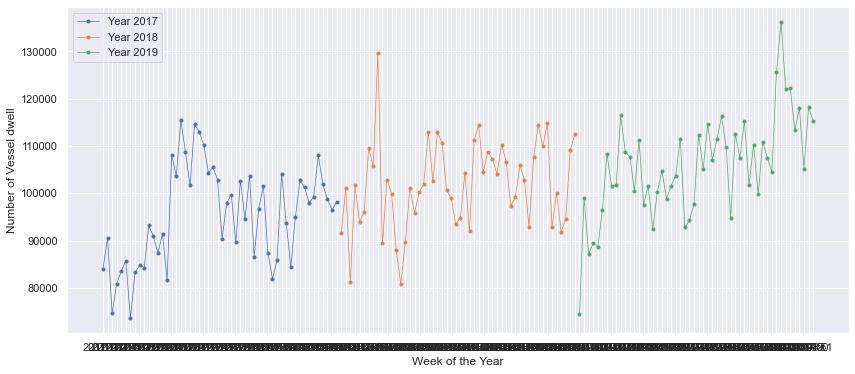

In [27]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(week_df2017['VESSEL_DWELL'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2017')
ax.plot(week_df2018['VESSEL_DWELL'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2018')
ax.plot(week_df2019['VESSEL_DWELL'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2019')
ax.set_xlabel('Week of the Year')
ax.set_ylabel('Number of Vessel dwell')
ax.legend()

### _Plot incoming sum_of_teu in time series_

In [28]:
# Dataset for discharge teu (increase of teu) and load teu (decrease of teu)
load_df = df2[df2['EVENT_C'] == 'LOAD']
disc_df = df2[df2['EVENT_C'] == 'DISC']

In [29]:
# Using disc_df as incoming teu
# Comparing sum of TEU across a years timeframe per weekly time series 
# Locate time series by year
disc_df_2017 = disc_df.loc['2017']
disc_df_2018 = disc_df.loc['2018']
disc_df_2019 = disc_df.loc['2019']

In [30]:
week_disc_df2017 = disc_df_2017.groupby(['ARRIVAL_WEEK'])
week_disc_df2018 = disc_df_2018.groupby(['ARRIVAL_WEEK'])
week_disc_df2019 = disc_df_2019.groupby(['ARRIVAL_WEEK'])

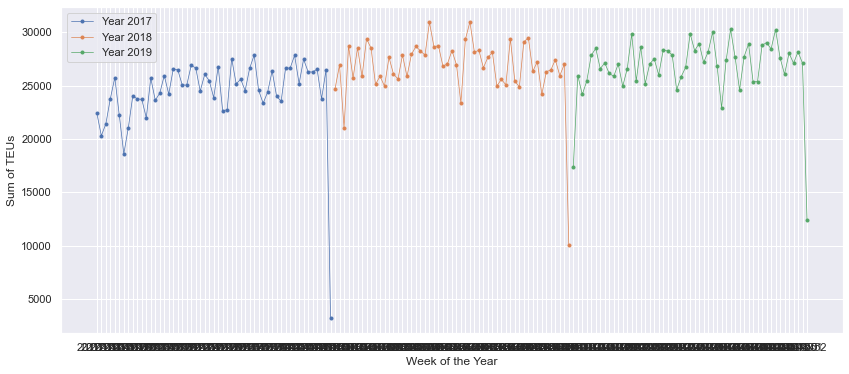

In [31]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(week_disc_df2017['SUMOFTEU_Q'].apply(np.sum, axis=0)[:53],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2017')
ax.plot(week_disc_df2018['SUMOFTEU_Q'].apply(np.sum, axis=0)[:53],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2018')
ax.plot(week_disc_df2019['SUMOFTEU_Q'].apply(np.sum, axis=0)[:53],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2019')
ax.set_xlabel('Week of the Year')
ax.set_ylabel('Sum of TEUs')
ax.legend()

In [32]:
# Check weekly arrival sum of teu in figures
week_disc_df = disc_df.groupby(['ARRIVAL_WEEK'])

Text(0, 0.5, 'Sum of TEU')

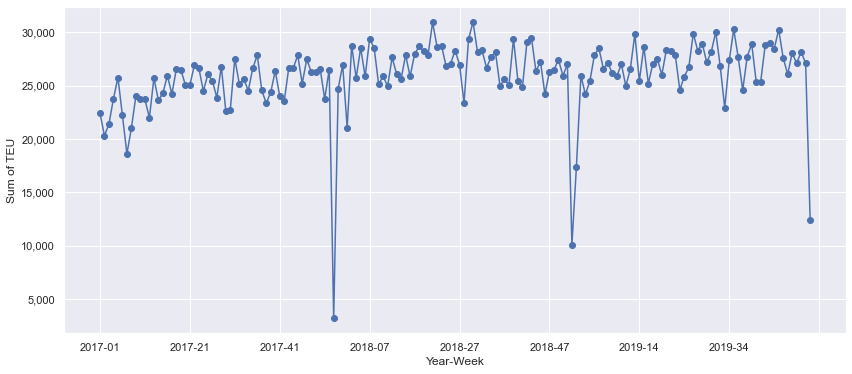

In [33]:
fig, ax = plt.subplots(figsize=(14,6))
ax = (week_disc_df['SUMOFTEU_Q'].apply(np.sum, axis=0)).plot(marker='o', linestyle ='-')
ax.set_xlabel('Year-Week')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('Sum of TEU')

In [34]:
vol_week = week_disc_df['SUMOFTEU_Q'].apply(np.sum, axis=0)
vol_week = pd.DataFrame(data = vol_week.values, index = vol_week.index, columns=['Volume of TEU'])
vol_week

Volume of TEU
ARRIVAL_WEEK               
2017-01            22429.25
2017-02            20320.50
2017-03            21416.75
2017-04            23785.50
2017-05            25768.50
...                     ...
2019-48            28052.00
2019-49            27115.50
2019-50            28182.25
2019-51            27108.75
2019-52            12442.25

[159 rows x 1 columns]

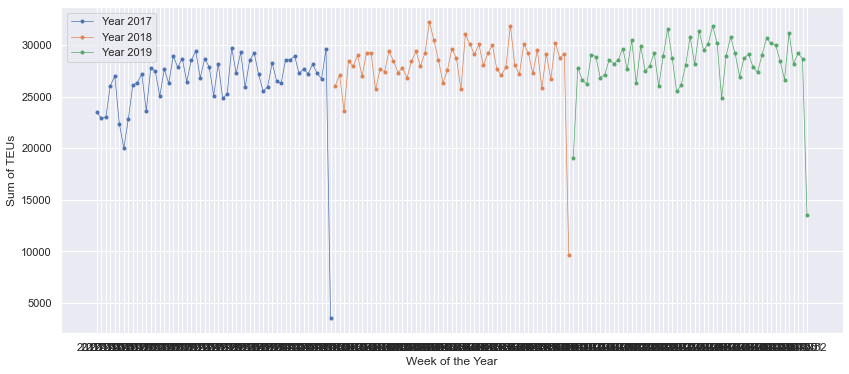

In [35]:
# 2-day moving Average - Sum of TEU per weekly time series 
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(week_disc_df2017['SUMOFTEU_Q_2'].apply(np.sum, axis=0)[:53],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2017')
ax.plot(week_disc_df2018['SUMOFTEU_Q_2'].apply(np.sum, axis=0)[:53],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2018')
ax.plot(week_disc_df2019['SUMOFTEU_Q_2'].apply(np.sum, axis=0)[:53],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2019')
ax.set_xlabel('Week of the Year')
ax.set_ylabel('Sum of TEUs')
ax.legend()

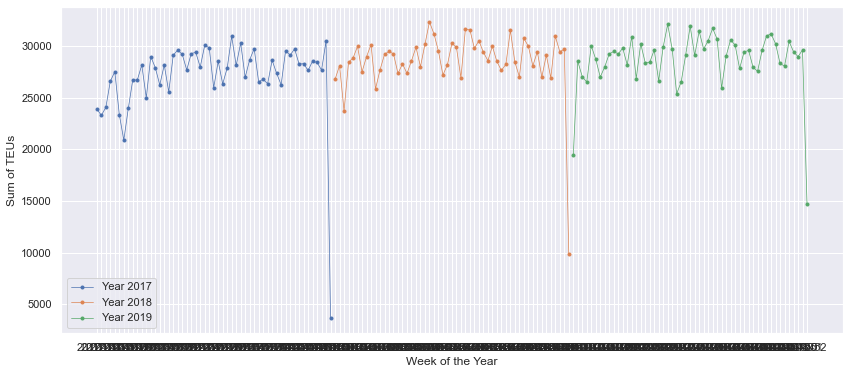

In [36]:
# 3-day moving Average - Sum of TEU per weekly time series 
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(week_disc_df2017['SUMOFTEU_Q_3'].apply(np.sum, axis=0)[:53],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2017')
ax.plot(week_disc_df2018['SUMOFTEU_Q_3'].apply(np.sum, axis=0)[:53],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2018')
ax.plot(week_disc_df2019['SUMOFTEU_Q_3'].apply(np.sum, axis=0)[:53],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2019')
ax.set_xlabel('Week of the Year')
ax.set_ylabel('Sum of TEUs')
ax.legend()

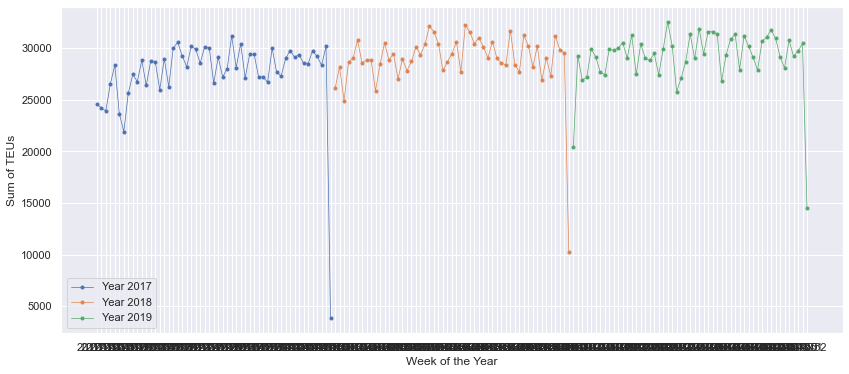

In [37]:
# 5-day moving Average - Sum of TEU per weekly time series 

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(week_disc_df2017['SUMOFTEU_Q_5'].apply(np.sum, axis=0)[:53],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2017')
ax.plot(week_disc_df2018['SUMOFTEU_Q_5'].apply(np.sum, axis=0)[:53],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2018')
ax.plot(week_disc_df2019['SUMOFTEU_Q_5'].apply(np.sum, axis=0)[:53],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2019')
ax.set_xlabel('Week of the Year')
ax.set_ylabel('Sum of TEUs')
ax.legend()

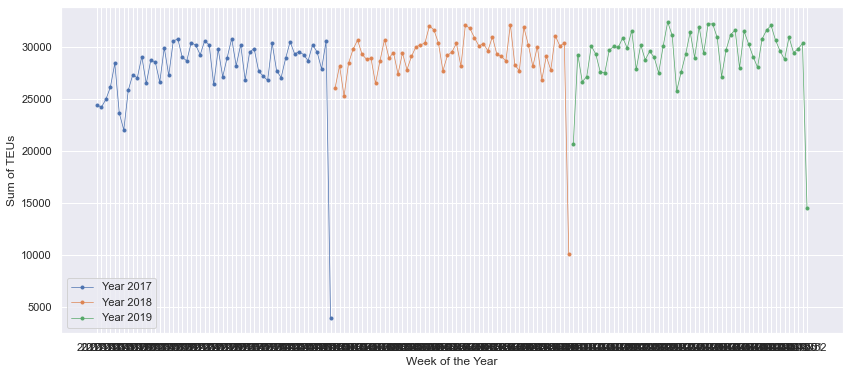

In [38]:
# 7-day moving Average - Sum of TEU per weekly time series 

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(week_disc_df2017['SUMOFTEU_Q_7'].apply(np.sum, axis=0)[:53],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2017')
ax.plot(week_disc_df2018['SUMOFTEU_Q_7'].apply(np.sum, axis=0)[:53],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2018')
ax.plot(week_disc_df2019['SUMOFTEU_Q_7'].apply(np.sum, axis=0)[:53],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2019')
ax.set_xlabel('Week of the Year')
ax.set_ylabel('Sum of TEUs')
ax.legend()

### _Plot container dwell in time series_

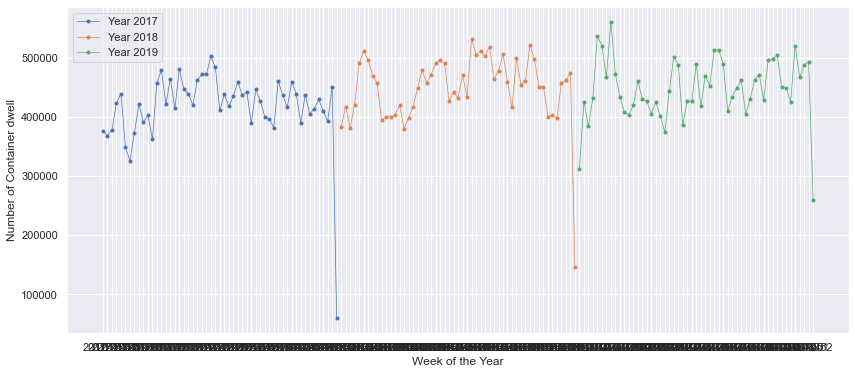

In [39]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(week_disc_df2017['CONTAINER_DWELL'].apply(np.sum, axis=0)[:53],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2017')
ax.plot(week_disc_df2018['CONTAINER_DWELL'].apply(np.sum, axis=0)[:53],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2018')
ax.plot(week_disc_df2019['CONTAINER_DWELL'].apply(np.sum, axis=0)[:53],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2019')
ax.set_xlabel('Week of the Year')
ax.set_ylabel('Number of Container dwell')
ax.legend()

### _Features Analysis_

In [40]:
# Define top load country
df2['LOAD_COUNTRY'].value_counts().head(10) / 100

Indonesia        1161.54
China            1005.91
Malaysia          715.11
Thailand          525.35
Viet Nam          514.60
India             474.74
United States     319.58
Japan             309.60
Australia         298.27
Bangladesh        250.31
Name: LOAD_COUNTRY, dtype: float64

In [41]:
top_load_country =  ['Indonesia','China','Malaysia','Thailand','Viet Nam','India']

In [42]:
# Define top discharge country
df2['DISC_COUNTRY'].value_counts().head(10) / 100

Indonesia        598.04
Australia        534.74
India            497.33
China            485.28
United States    452.14
Malaysia         446.84
Viet Nam         372.94
Thailand         321.65
Japan            259.38
Bangladesh       206.95
Name: DISC_COUNTRY, dtype: float64

In [43]:
top_disc_country = ['Indonesia','Australia','China','India','United States','Malaysia']

In [80]:
# Check vessel distribution
df2['VESSEL_TYPE_M1'].value_counts()/np.float(len(df2))

<ipython-input-80-51344a5ae752>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df2['VESSEL_TYPE_M1'].value_counts()/np.float(len(df2))


Feeder          0.346001
Intermediate    0.309662
Neo-Panamax     0.295121
Post-Panamax    0.049216
Name: VESSEL_TYPE_M1, dtype: float64

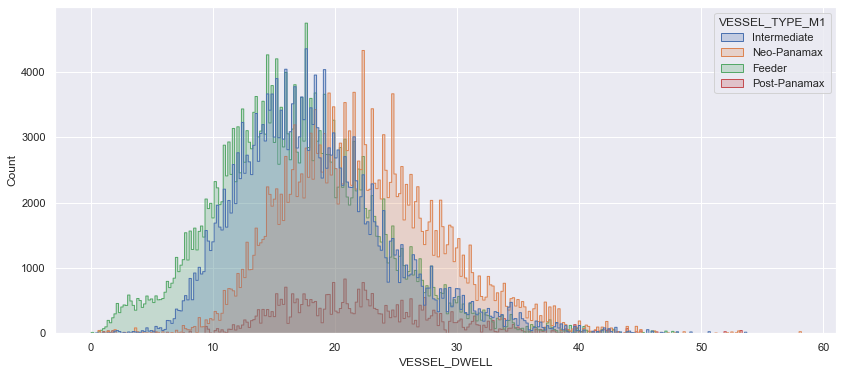

In [81]:
# Plot histogram of vessel dwell time and count of vessel type
get_hist(df2,X = 'VESSEL_DWELL' , HUE='VESSEL_TYPE_M1', TITLE=None)

### Average Target Labels Analysis

#### Vessel dwell

In [44]:
def get_vessel_dwell(df):  
    vessel_dwell=df.groupby(by=['DISC_COUNTRY','LOAD_COUNTRY','VESSEL_TYPE_M1','DIRECTION_C1',
                            'ARRIVAL_DATE','WEEK_OF_YEAR'])['VESSEL_DWELL'].mean().reset_index()      
    return vessel_dwell

In [45]:
vessel_dwell = get_vessel_dwell(df2)
vessel_dwell = vessel_dwell.sort_values('ARRIVAL_DATE')
vessel_dwell = vessel_dwell.set_index('ARRIVAL_DATE')

In [46]:
# Create top load country list
vessel_dwell_load_country = vessel_dwell[vessel_dwell['LOAD_COUNTRY'].isin(top_load_country)]

# Create top discharge country list
vessel_dwell_disc_country = vessel_dwell[vessel_dwell['DISC_COUNTRY'].isin(top_disc_country)]

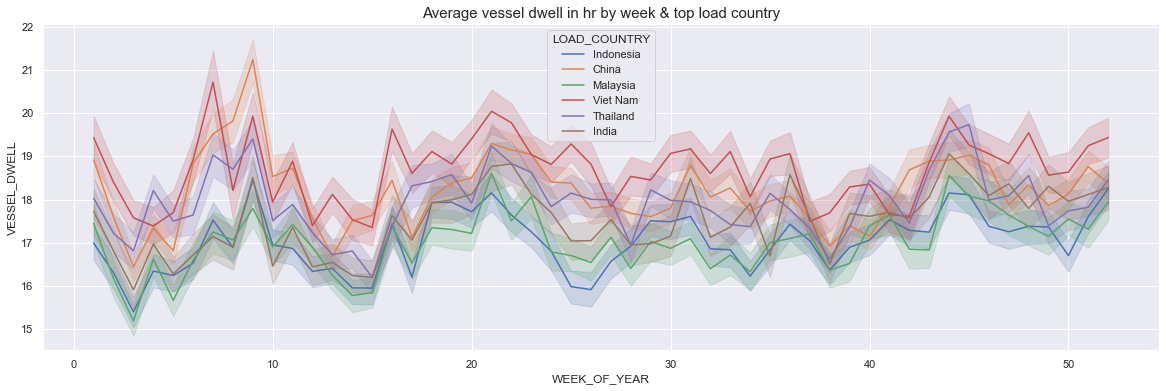

In [47]:
# 'LOAD_COUNTRY'
get_line(vessel_dwell_load_country,vessel_dwell_load_country['WEEK_OF_YEAR'],vessel_dwell_load_country['VESSEL_DWELL'],
         HUE = 'LOAD_COUNTRY' ,TITLE='Average vessel dwell in hr by week & top load country')

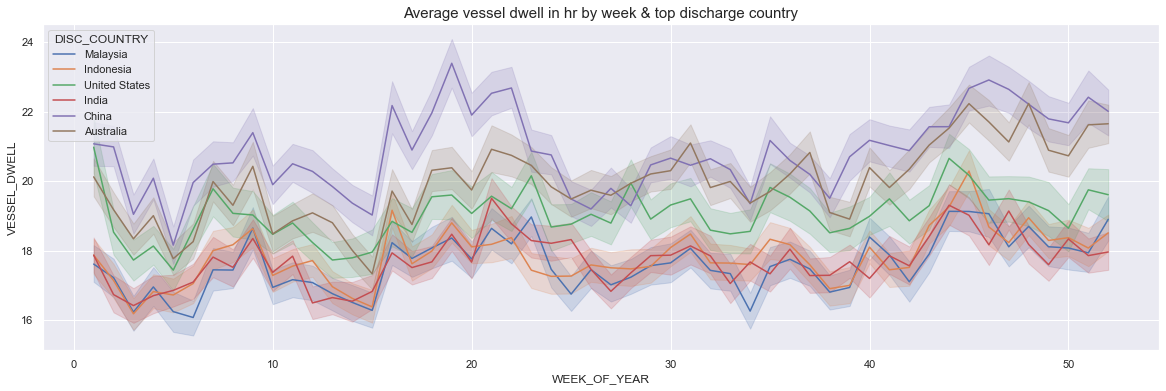

In [48]:
# 'DISC_COUNTRY'
get_line(vessel_dwell_disc_country,vessel_dwell_disc_country['WEEK_OF_YEAR'],vessel_dwell_disc_country['VESSEL_DWELL'],
         HUE = 'DISC_COUNTRY' ,TITLE='Average vessel dwell in hr by week & top discharge country')

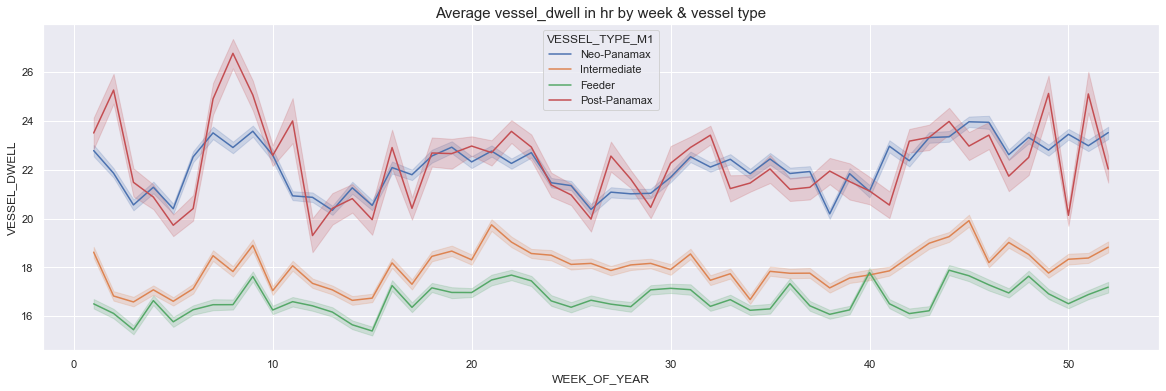

In [49]:
# 'VESSEL_TYPE_M1'
get_line(vessel_dwell,vessel_dwell['WEEK_OF_YEAR'],vessel_dwell['VESSEL_DWELL'],
         HUE='VESSEL_TYPE_M1',TITLE='Average vessel_dwell in hr by week & vessel type')

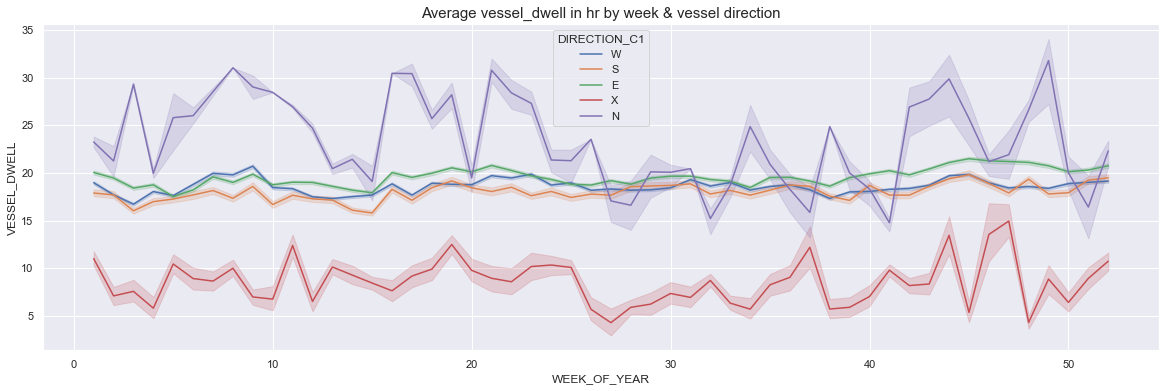

In [50]:
# 'DIRECTION_C1'
get_line(vessel_dwell,vessel_dwell['WEEK_OF_YEAR'],vessel_dwell['VESSEL_DWELL'],
         HUE='DIRECTION_C1',TITLE='Average vessel_dwell in hr by week & vessel direction')

#### Sum of TEU

In [51]:
# Groupby SUMOFTEU_Q.mean(average)
def get_sumofteu(df):
    sumofteu=df.groupby(by=['EVENT_C','CNTR_STATUS_C','DISC_COUNTRY','LOAD_COUNTRY',
                            'VESSEL_TYPE_M1','SERVICE_C1','DIRECTION_C1','OPR_GROUP_C',
                            'ARRIVAL_DATE','ARRIVAL_WEEK','ARRIVAL_MONTH','WEEK_OF_YEAR','MONTH_OF_YEAR'])['SUMOFTEU_Q'].mean().reset_index()
    return sumofteu

In [52]:
sumofteu = get_sumofteu(disc_df)
sumofteu = sumofteu.sort_values('ARRIVAL_DATE')
sumofteu = sumofteu.set_index('ARRIVAL_DATE')

In [53]:
# Create top load country list
sumofteu_load_country = sumofteu[sumofteu['LOAD_COUNTRY'].isin(top_load_country)]

# Create top discharge country list
sumofteu_disc_country = sumofteu[sumofteu['DISC_COUNTRY'].isin(top_disc_country)]

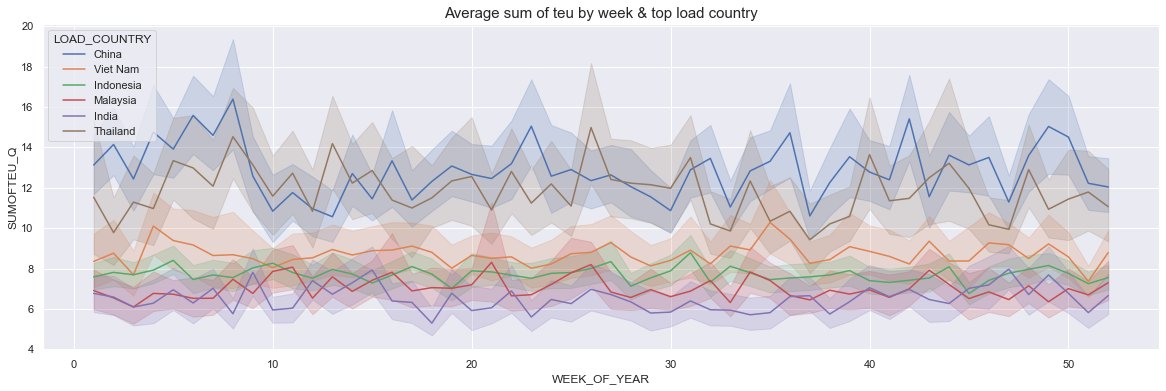

In [54]:
# 'LOAD_COUNTRY'
get_line(sumofteu_load_country,sumofteu_load_country['WEEK_OF_YEAR'],sumofteu_load_country['SUMOFTEU_Q'],
         HUE = 'LOAD_COUNTRY' ,TITLE='Average sum of teu by week & top load country')

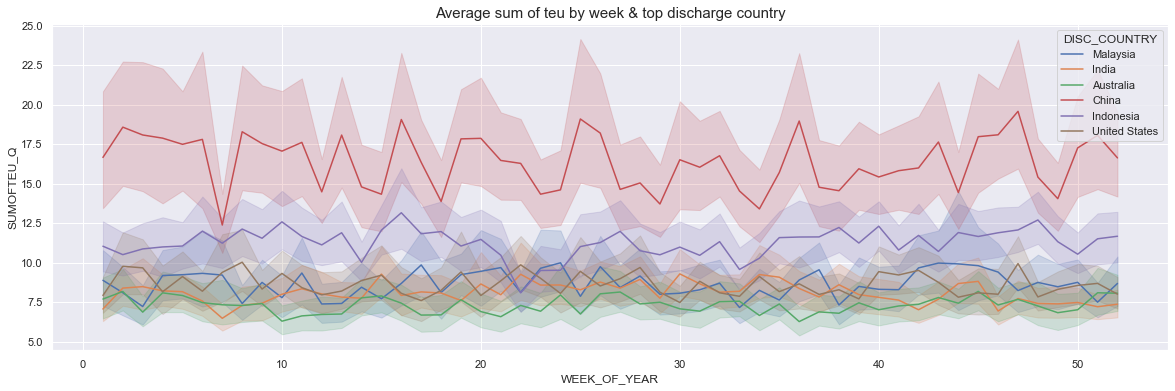

In [55]:
# 'DISC_COUNTRY'
get_line(sumofteu_disc_country,sumofteu_disc_country['WEEK_OF_YEAR'],sumofteu_disc_country['SUMOFTEU_Q'],
         HUE = 'DISC_COUNTRY' ,TITLE='Average sum of teu by week & top discharge country')

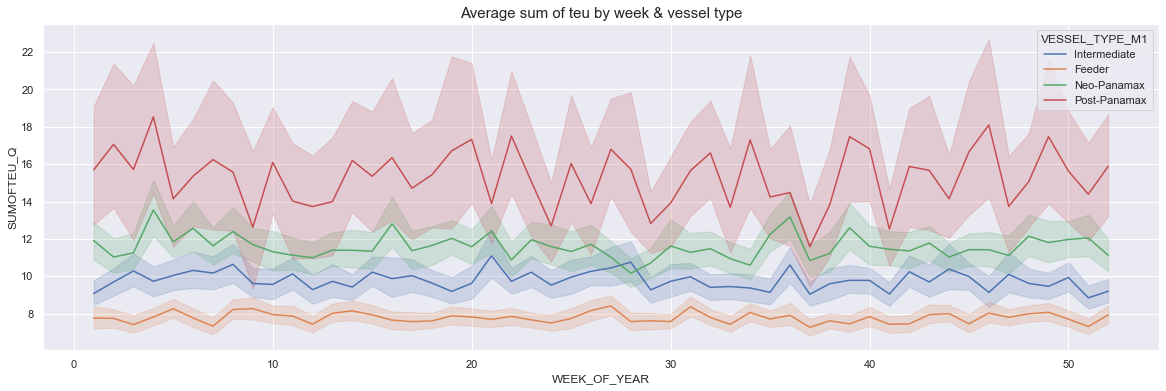

In [56]:
# 'VESSEL_TYPE_M1'
get_line(sumofteu,sumofteu['WEEK_OF_YEAR'],sumofteu['SUMOFTEU_Q'],
         HUE='VESSEL_TYPE_M1',TITLE='Average sum of teu by week & vessel type')

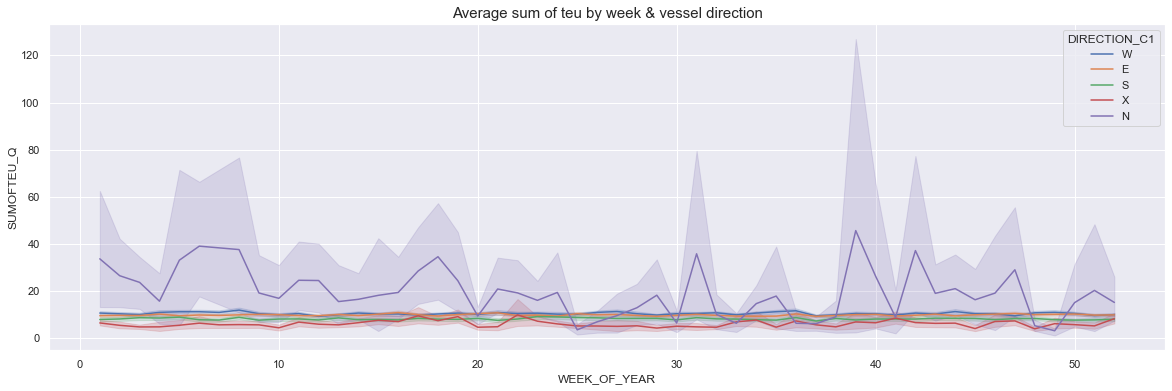

In [57]:
# 'DIRECTION_C1'
get_line(sumofteu,sumofteu['WEEK_OF_YEAR'],sumofteu['SUMOFTEU_Q'],
         HUE='DIRECTION_C1',TITLE='Average sum of teu by week & vessel direction')

#### Container dwell

In [58]:
def get_container_dwell(df):    
    container_dwell=df.groupby(by=['DISC_COUNTRY','LOAD_COUNTRY','VESSEL_TYPE_M1','DIRECTION_C1',
                            'ARRIVAL_DATE','WEEK_OF_YEAR'])['CONTAINER_DWELL'].mean().reset_index()
    return container_dwell

In [59]:
container_dwell = get_container_dwell(disc_df)
container_dwell = container_dwell.sort_values('ARRIVAL_DATE')
container_dwell = container_dwell.set_index('ARRIVAL_DATE')

In [60]:
# Create top load country list
container_dwell_load_country = container_dwell[container_dwell['LOAD_COUNTRY'].isin(top_load_country)]

# Create top discharge country list
container_dwell_disc_country = container_dwell[container_dwell['DISC_COUNTRY'].isin(top_disc_country)]

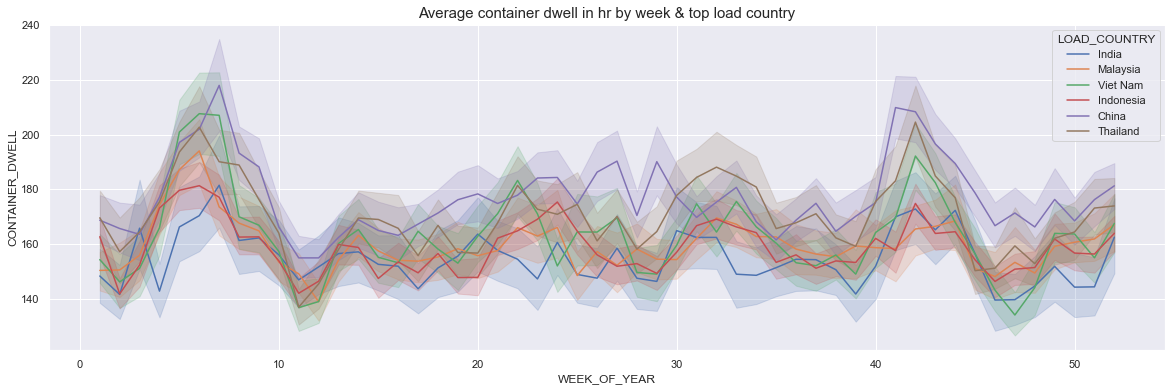

In [61]:
# 'LOAD_COUNTRY'
get_line(container_dwell_load_country,container_dwell_load_country['WEEK_OF_YEAR'],container_dwell_load_country['CONTAINER_DWELL'],
         HUE = 'LOAD_COUNTRY' ,TITLE='Average container dwell in hr by week & top load country')

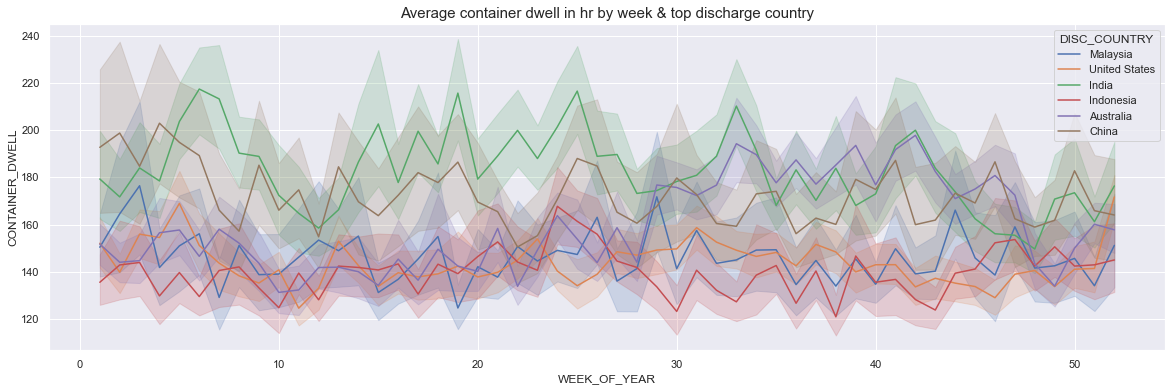

In [62]:
# 'DISC_COUNTRY'
get_line(container_dwell_disc_country,container_dwell_disc_country['WEEK_OF_YEAR'],container_dwell_disc_country['CONTAINER_DWELL'],
         HUE = 'DISC_COUNTRY' ,TITLE='Average container dwell in hr by week & top discharge country')

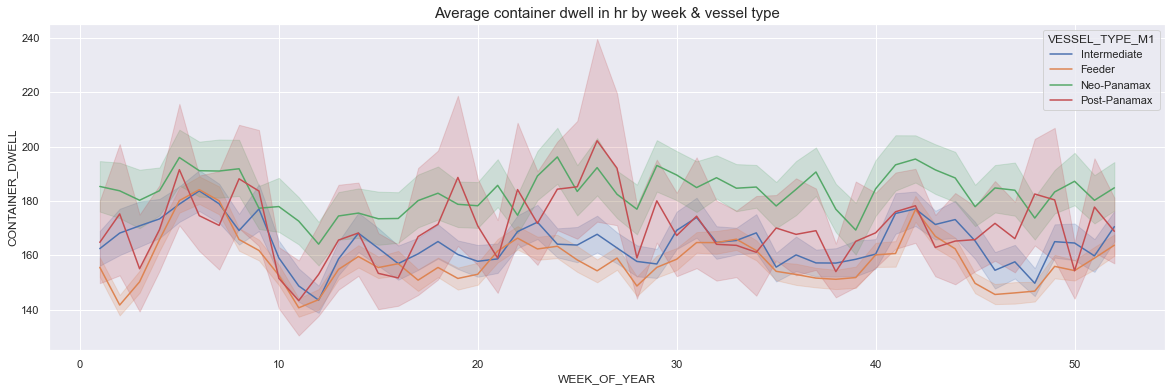

In [63]:
# 'VESSEL_TYPE_M1'
get_line(container_dwell,container_dwell['WEEK_OF_YEAR'],container_dwell['CONTAINER_DWELL'],
         HUE='VESSEL_TYPE_M1',TITLE='Average container dwell in hr by week & vessel type')

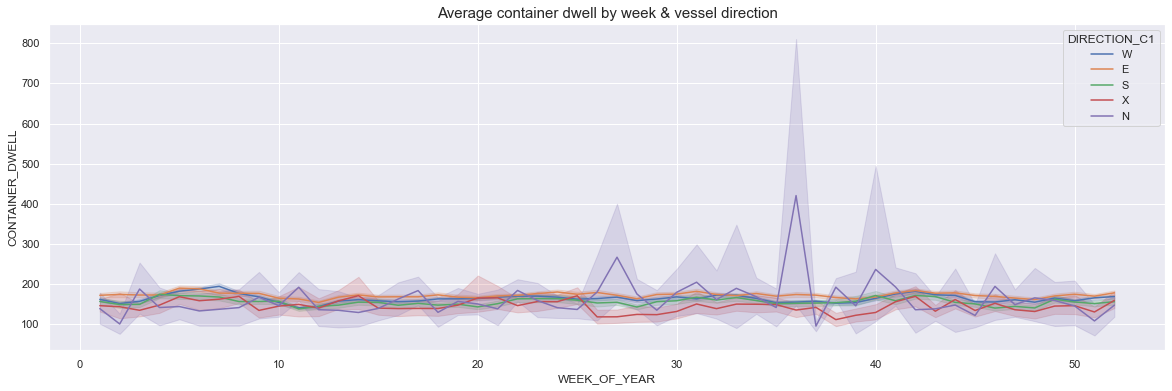

In [64]:
# 'DIRECTION_C1'
get_line(container_dwell,container_dwell['WEEK_OF_YEAR'],container_dwell['CONTAINER_DWELL'],
         HUE='DIRECTION_C1',TITLE='Average container dwell by week & vessel direction')

<AxesSubplot:>

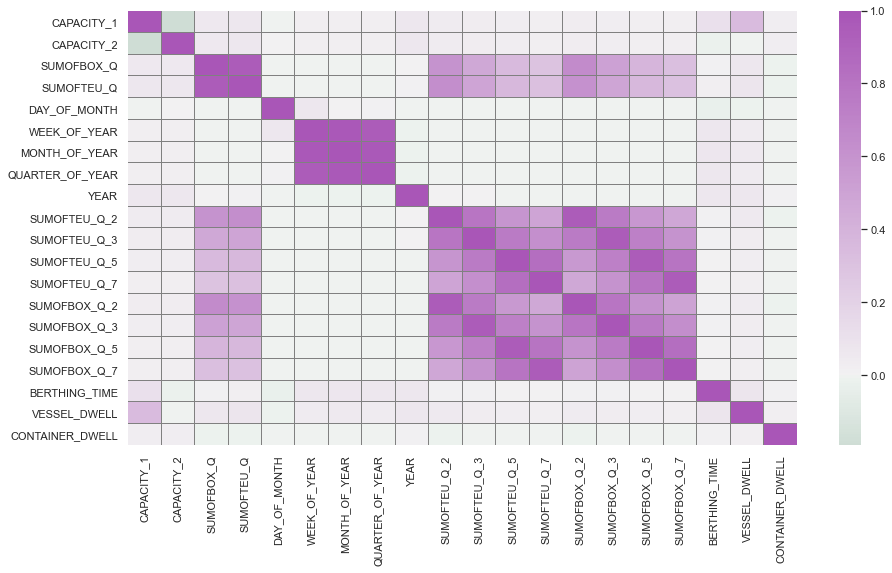

In [65]:
# Check correlation
fig, ax = plt.subplots(figsize = (15,8))
mycmap = sns.diverging_palette(145, 300, s = 60, as_cmap = True)
sns.heatmap(data = df2.corr(), center = 0.0, square = False, cmap = mycmap, linewidths = 0.01, 
            linecolor = 'gray')

#### Results:

After detailed features engineering and analysis, we narrow down to below three target labels for modelling.

- "SUMOFTEU_Q_NEXTWEEK"
- "VESSEL_DWELL"
- "CONTAINER_DWELL"

## 5. Machine Learning Model <a class="anchor" id="5.MachineLearningModel"></a>

#### Machine learning utils

In [66]:
# Regression score metrics

def print_metrics(y_true, y_predicted, n_parameters):
    
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    mape=np.mean(np.abs((y_true - y_predicted) / y_true)) * 100
    
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2 / Accuracy         = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj)) 
    print('Mean Absolute Percentage Error  =' + str(mape))

In [67]:
# Classifier score metrics

def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

def print_metrics2(labels, probs, threshold):
    scores = score_model(probs, threshold)
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Actual negative    Actual positive')
    print('Score negative    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Score positive    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    print('AUC             %0.2f' % sklm.roc_auc_score(labels, probs[:,1]))
    print('Macro precision %0.2f' % float((float(metrics[0][0]) + float(metrics[0][1]))/2.0))
    print('Macro recall    %0.2f' % float((float(metrics[1][0]) + float(metrics[1][1]))/2.0))
    print(' ')
    print('           Negative     Positive')
    print('Num case   %6d'   % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])

In [68]:
def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.figure(figsize=(10,6))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show() 

In [69]:
def get_count_confusion_metrics(model, x , y):
    
    plot_confusion_matrix(model, x , y)  
    fig = plt.gcf().set_size_inches(12, 6)

### AUTO-ARIMA Model for SUMOFTEU_Q weekly prediction

#### Pre-processing data for modeling

Using disc_df discharge dataset for modeling

In [70]:
disc_df1 = disc_df.copy()

In [71]:
# Groupby weekly basis
disc_df1 = disc_df1.groupby(['ARRIVAL_WEEK']).sum()

In [72]:
disc_df1

CAPACITY_1  CAPACITY_2  SUMOFBOX_Q  SUMOFTEU_Q  DAY_OF_MONTH  \
ARRIVAL_WEEK                                                                 
2017-01       13235800.0  13685700.0       14895    22429.25          9122   
2017-02       14665300.0  13796300.0       13493    20320.50         25493   
2017-03       13202400.0  13856600.0       14199    21416.75         41473   
2017-04       12323800.0  16019200.0       15562    23785.50         60317   
2017-05       14721300.0  15696500.0       17492    25768.50         34864   
...                  ...         ...         ...         ...           ...   
2019-48       19376000.0  21572600.0       17911    28052.00         11199   
2019-49       16445200.0  21468900.0       17664    27115.50         28194   
2019-50       18503800.0  21849500.0       17970    28182.25         49593   
2019-51       18507300.0  22340800.0       17342    27108.75         71166   
2019-52        8512300.0  10469400.0        8105    12442.25         39604   

              WEEK_OF_YEAR  MONTH_OF_YEAR  QUARTER_OF_YEAR     YEAR  \
ARRIVAL_WEEK                                                          
2017-01              16059           2238             2238  4514046   
2017-02               4286           2303             2303  4645151   
2017-03               6589           2279             2279  4596743   
2017-04               9321           2405             2405  4850885   
2017-05              12487           4078             2555  5153435   
...                    ...            ...              ...      ...   
2019-48             139048          34152            11384  5746074   
2019-49             128510          30924            10308  5202963   
2019-50             139880          33000            11000  5552250   
2019-51             146615          33912            11304  5705694   
2019-52              27536          15864             5288  2669118   

              SUMOFTEU_Q_2  SUMOFTEU_Q_3  SUMOFTEU_Q_5  SUMOFTEU_Q_7  \
ARRIVAL_WEEK                                                           
2017-01          23515.125  23893.833333      24592.05  24479.571429   
2017-02          22927.500  23277.833333      24221.25  24221.928571   
2017-03          23018.375  24038.500000      23941.75  24974.464286   
2017-04          26086.125  26577.416667      26551.65  26139.428571   
2017-05          27027.000  27499.000000      28357.90  28448.250000   
...                    ...           ...           ...           ...   
2019-48          31217.875  30425.666667      30781.20  30965.785714   
2019-49          28211.125  29433.250000      29234.75  29486.500000   
2019-50          29226.750  28955.083333      29735.70  29834.250000   
2019-51          28712.000  29605.166667      30471.30  30378.928571   
2019-52          13523.875  14729.500000      14466.70  14487.142857   

              SUMOFBOX_Q_2  SUMOFBOX_Q_3  SUMOFBOX_Q_5  SUMOFBOX_Q_7  \
ARRIVAL_WEEK                                                           
2017-01            15578.0  15635.666667       15967.2  16008.428571   
2017-02            15121.5  15251.333333       15957.2  15949.285714   
2017-03            15124.5  15807.000000       15573.4  16200.714286   
2017-04            17015.0  17307.000000       17240.2  16930.000000   
2017-05            17900.5  18030.333333       18551.2  18630.142857   
...                    ...           ...           ...           ...   
2019-48            20289.5  19699.333333       19956.2  20131.857143   
2019-49            18415.0  19193.666667       19045.6  19141.714286   
2019-50            18585.0  18463.666667       19117.4  19291.857143   
2019-51            18645.0  19240.000000       19894.0  19836.000000   
2019-52             8737.5   9492.333333        9408.6   9434.571429   

              BERTHING_TIME  VESSEL_DWELL  CONTAINER_DWELL  
ARRIVAL_WEEK                                                
2017-01         2971.933333  40683.800000    376107.633333  
2017-02         53

#### ADF test for stationarity of time series

In [73]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(disc_df1.SUMOFTEU_Q)

(0.01, False)

Results:

From the above result (0.01, False), we can conclude that the data is non-stationary. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series to make the data stationary while building the Auto ARIMA model.

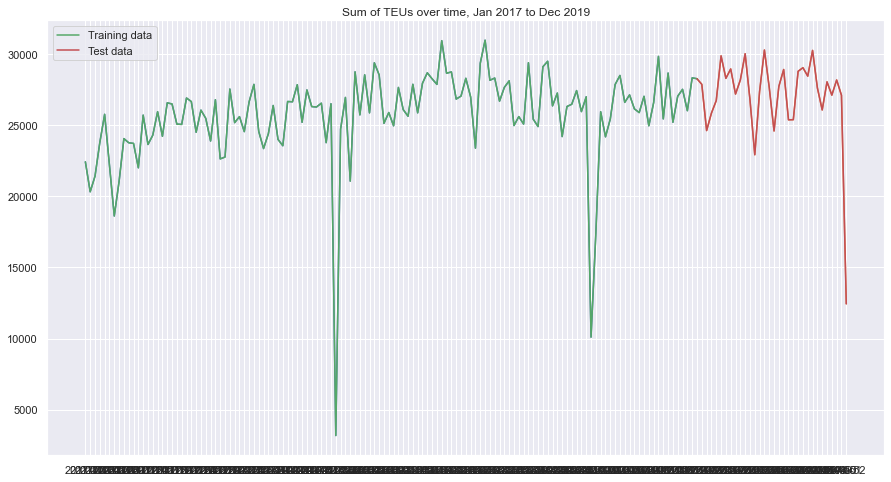

In [74]:
# Pre-Check train test result
train = disc_df1.SUMOFTEU_Q[:128]  # 80% train
test = disc_df1.SUMOFTEU_Q[-32:]   # 20% test

plt.figure(figsize=(15,8))
plt.plot(train)
plt.plot(test)
plt.plot(train, label = 'Training data')
plt.plot(test, label = 'Test data')
plt.title('Sum of TEUs over time, Jan 2017 to Dec 2019')
plt.legend()
plt.show()

#### Model training

In [75]:
arima_model = auto_arima(train,start_p=0, d=1, start_q=0,
                        max_p=5, max_d=5, max_q=5, start_P=0,
                        D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                        m=12, seasonal=True, error_action='warn', trace=True,
                        supress_warning=True, stepwise=True, random_state=20, 
                        n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2299.119, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2259.976, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2231.582, Time=0.70 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2268.828, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2240.151, Time=0.42 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.27 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2248.271, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.41 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2259.745, Time=0.60 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2233.429, Time=0.97 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2233.395, Time=0.87 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2241.948, Time=0.65 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=1.93 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=2232.071, Time=1.43 sec

Best model:  ARIMA(0,1,1)(0,1,1)[

#### Prediction on test set

In [76]:
sumofteu_prediction = pd.DataFrame(arima_model.predict(n_periods=32),index=test.index)
sumofteu_prediction.columns = ['Predicted_sumofTEU']
sumofteu_prediction

Predicted_sumofTEU
ARRIVAL_WEEK                    
2019-21             29223.542988
2019-22             23833.948736
2019-23             26779.456861
2019-24             30042.671733
2019-25             28669.338484
2019-26             29210.569957
2019-27             28646.376696
2019-28             29111.023058
2019-29             28079.514524
2019-30             28301.234402
2019-31             29121.004419
2019-32             28572.193534
2019-33             30093.176716
2019-34             24703.582464
2019-35             27649.090588
2019-36             30912.305460
2019-37             29538.972212
2019-38             30080.203684
2019-39             29516.010424
2019-40             29980.656786
2019-41             28949.148251
2019-42             29170.868129
2019-43             29990.638147
2019-44             29441.827262
2019-45             30962.810443
2019-46             25573.216191
2019-47             28518.724315
2019-48             31781.939188
2019-49             30408.605939
2019-50             30949.837411
2019-51             30385.644151
2019-52             30850.290513

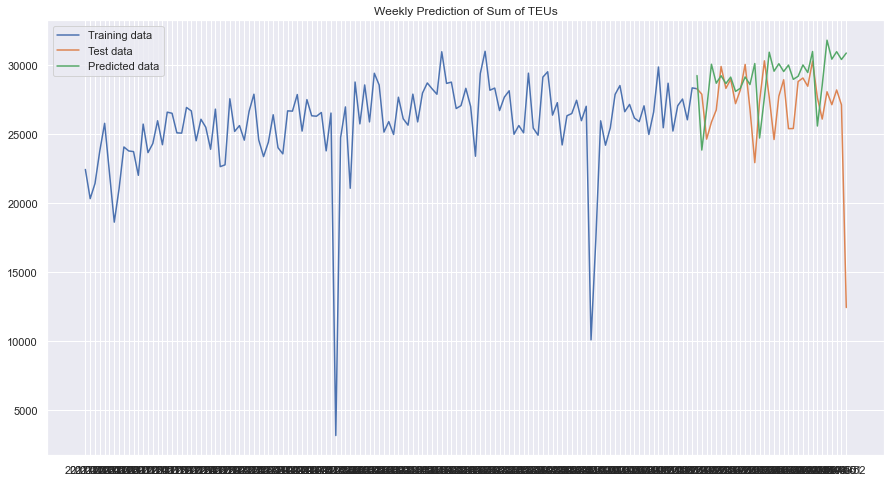

In [77]:
# Plot prediction result
plt.figure(figsize=(15,8))
plt.plot(train, label = 'Training data')
plt.plot(test, label = 'Test data')
plt.plot(sumofteu_prediction, label = 'Predicted data')
plt.legend()
plt.title('Weekly Prediction of Sum of TEUs')
plt.show()

#### Results:
Based on the result from auto-ARIMA, the Best model:  Best model:  ARIMA(0,1,1)(0,1,1)[12]   

#### Check performance metrics

In [78]:
print_metrics(test, sumofteu_prediction['Predicted_sumofTEU'], 31)

Mean Square Error      = 18232023.411005415
Root Mean Square Error = 4269.897353684912
Mean Absolute Error    = 2778.0734048751847
Median Absolute Error  = 2250.580272341138
R^2 / Accuracy         = -0.8652573722850809
Adjusted R^2           = -56.822978540837504
Mean Absolute Percentage Error  =12.941295976806702


### Classifier Model for vessel dwell

#### Pre-processing data
Using df2 (full variables) for modeling

(array([1.5210e+03, 4.9670e+03, 6.0870e+03, 1.2749e+04, 2.7377e+04,
        4.7432e+04, 6.9146e+04, 9.2455e+04, 9.8813e+04, 9.8874e+04,
        8.8314e+04, 7.7609e+04, 5.9740e+04, 4.4106e+04, 3.2986e+04,
        2.3691e+04, 1.5924e+04, 1.0967e+04, 6.6460e+03, 4.8800e+03,
        2.4050e+03, 1.5310e+03, 8.7700e+02, 4.8100e+02, 2.2000e+02,
        6.0000e+01, 9.2000e+01, 1.6200e+02, 0.0000e+00, 3.2000e+01]),
 array([1.66666667e-02, 1.95444444e+00, 3.89222222e+00, 5.83000000e+00,
        7.76777778e+00, 9.70555556e+00, 1.16433333e+01, 1.35811111e+01,
        1.55188889e+01, 1.74566667e+01, 1.93944444e+01, 2.13322222e+01,
        2.32700000e+01, 2.52077778e+01, 2.71455556e+01, 2.90833333e+01,
        3.10211111e+01, 3.29588889e+01, 3.48966667e+01, 3.68344444e+01,
        3.87722222e+01, 4.07100000e+01, 4.26477778e+01, 4.45855556e+01,
        4.65233333e+01, 4.84611111e+01, 5.03988889e+01, 5.23366667e+01,
        5.42744444e+01, 5.62122222e+01, 5.81500000e+01]),
 <BarContainer object of 30 

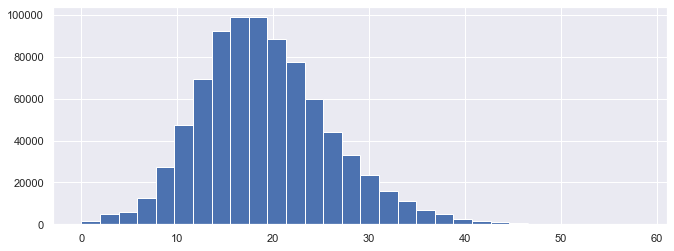

In [79]:
# Check distribution of vessel dwell 
plt.hist(data=df2, x='VESSEL_DWELL', bins=30)

In [82]:
# Create binary label base on 75 percentile value @ 23hr
df2['VESSEL_DWELL_STATUS'] = np.where(df2['VESSEL_DWELL'] > 23, 'Above 23h', 'Below 23h')

In [83]:
# Prepare drop list
drop_list = ['EVENT_C', 'CNTR_STATUS_C','ABBR_VESSEL_M1','BTR1','ATD1', 'ATU1', 'SERVICE_C1','ABBR_VESSEL_M2','BTR2', 'ATD2', 
             'ATU2','LINE_C2_GROUP', 'SERVICE_C2', 'DIRECTION_C2', 'CAPACITY_2','DERIVED_CNTR_PURP_C','OPR_GROUP_C', 
             'SUMOFBOX_Q','QUARTER_OF_YEAR', 'YEAR', 'VESSEL_TYPE_M2','SUMOFBOX_Q_2', 
             'SUMOFBOX_Q_3','SUMOFBOX_Q_5', 'SUMOFBOX_Q_7','VESSEL_DWELL']

In [84]:
# Drop variables
ves_dwell_df = df2.drop(drop_list, axis = 1)

In [85]:
# Filter to Neo-Panamax as it has significant volumns and above average dwell time (if its running for big dataset)
ves_dwell_df = ves_dwell_df[ves_dwell_df['VESSEL_TYPE_M1'] == 'Neo-Panamax']

In [86]:
ves_dwell_df

DISC_PORT1_C LOAD_PORT_C LINE_C1_GROUP DIRECTION_C1  CAPACITY_1  \
ARRIVAL_DATE                                                                   
2017-01-01          DEHAM       PHMNL          L367            W     13000.0   
2017-01-01          BEANR       VNVUT          L391            W      9000.0   
2017-01-01          GBSOU       CNSHA          L367            W     13000.0   
2017-01-01          DEHAM       MYPKG          L367            W     13000.0   
2017-01-01          DEHAM       AUMEL          L367            W     13000.0   
...                   ...         ...           ...          ...         ...   
2019-12-31          GRPIR       MYPGU          L367            W     14000.0   
2019-12-31          ITGIT       MYPKG          L348            W      9000.0   
2019-12-31          OMSOH       USOAK          L344            W     10000.0   
2019-12-31          CNTXG       GBFXT          L390            E     15000.0   
2019-12-31          AUMEL       SIKOP          L390            E     15000.0   

              SUMOFTEU_Q ARRIVAL_WEEK ARRIVAL_MONTH  DAY_OF_MONTH  \
ARRIVAL_DATE                                                        
2017-01-01           4.0      2017-01       2017-01             1   
2017-01-01          10.0      2017-01       2017-01             1   
2017-01-01           2.0      2017-01       2017-01             1   
2017-01-01           1.0      2017-01       2017-01             1   
2017-01-01           4.0      2017-01       2017-01             1   
...                  ...          ...           ...           ...   
2019-12-31           2.0      2019-52       2019-12            31   
2019-12-31           7.0      2019-52       2019-12            31   
2019-12-31           2.0      2019-52       2019-12            31   
2019-12-31           4.0      2019-52       2019-12            31   
2019-12-31          14.0      2019-52       2019-12            31   

              WEEK_OF_YEAR  MONTH_OF_YEAR    DISC_COUNTRY    LOAD_COUNTRY  \
ARRIVAL_DATE                                                                
2017-01-01              52              1         Germany     Philippines   
2017-01-01              52              1         Belgium        Viet Nam   
2017-01-01              52              1  United Kingdom           China   
2017-01-01              52              1         Germany        Malaysia   
2017-01-01              52              1         Germany       Australia   
...                    ...            ...             ...             ...   
2019-12-31               1             12          Greece        Malaysia   
2019-12-31               1             12           Italy        Malaysia   
2019-12-31               1             12            Oman   United States   
2019-12-31               1             12           China  United Kingdom   
2019-12-31               1             12       Australia        Slovenia   

             VESSEL_TYPE_M1 CONTAINER_LOAD_VESSEL_TYPE  SUMOFTEU_Q_2  \
ARRIVAL_DATE                                                           
2017-01-01      Neo-Panamax                Neo-Panamax          17.0   
2017-01-01      Neo-Panamax                Neo-Panamax           8.0   
2017-01-01      Neo-Panamax                Neo-Panamax           2.0   
2017-01-01      Neo-Panamax                Neo-Panamax           5.5   
2017-01-01      Neo-Panamax                Neo-Panamax          21.0   
...                     ...                        ...           ...   
2019-12-31      Neo-Panamax                Neo-Panamax          26.5   
2019-12-31      Neo-Panamax                Neo-Panamax          20.0   
2019-12-31      Neo-Panamax                Neo-Panamax           4.5   
2019-12-31      Neo-Panamax                Neo-Panamax           7.0   
2019-12-31      Neo-Panamax               Intermediate           9.0   

              SUMOFTEU_Q_3  SUMOFTEU_Q_5  SUMOFTEU_Q_7  BERTHING_TIME  \
ARRIVAL_DATE                                                  

In [87]:
ves_dwell_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244993 entries, 2017-01-01 to 2019-12-31
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   DISC_PORT1_C                244993 non-null  object 
 1   LOAD_PORT_C                 244993 non-null  object 
 2   LINE_C1_GROUP               244993 non-null  object 
 3   DIRECTION_C1                244993 non-null  object 
 4   CAPACITY_1                  244993 non-null  float64
 5   SUMOFTEU_Q                  244993 non-null  float64
 6   ARRIVAL_WEEK                244993 non-null  object 
 7   ARRIVAL_MONTH               244993 non-null  object 
 8   DAY_OF_MONTH                244993 non-null  int64  
 9   WEEK_OF_YEAR                244993 non-null  int64  
 10  MONTH_OF_YEAR               244993 non-null  int64  
 11  DISC_COUNTRY                244993 non-null  object 
 12  LOAD_COUNTRY                244993 non-null  object 
 13

In [88]:
# Select features

cat_col = ['DISC_PORT1_C', 'LOAD_PORT_C','LINE_C1_GROUP','DIRECTION_C1','ARRIVAL_MONTH','ARRIVAL_WEEK', 
           'DISC_COUNTRY','LOAD_COUNTRY','VESSEL_TYPE_M1','CONTAINER_LOAD_VESSEL_TYPE','VESSEL_DWELL_STATUS']

num_col = ['CAPACITY_1', 'SUMOFTEU_Q','DAY_OF_MONTH', 'WEEK_OF_YEAR','MONTH_OF_YEAR','SUMOFTEU_Q_2', 
           'SUMOFTEU_Q_3','SUMOFTEU_Q_5', 'SUMOFTEU_Q_7', 'BERTHING_TIME', 'CONTAINER_DWELL']

#### Random over-sampling for imbalanced classes of target label

In [89]:
# Check distribution for target label
ves_dwell_df['VESSEL_DWELL_STATUS'].value_counts() / len(ves_dwell_df)

Below 23h    0.583829
Above 23h    0.416171
Name: VESSEL_DWELL_STATUS, dtype: float64

In [90]:
ves_dwell_df.VESSEL_DWELL_STATUS.value_counts()

Below 23h    143034
Above 23h    101959
Name: VESSEL_DWELL_STATUS, dtype: int64

In [130]:
# Define dataset
class_0 = ves_dwell_df.drop('VESSEL_DWELL_STATUS', axis = 1)
class_1 = ves_dwell_df.VESSEL_DWELL_STATUS     

# Define random oversampling strategy
ros = RandomOverSampler(random_state=42)
class_0_ros, class_1_ros = ros.fit_resample(class_0 , class_1)

# Merge data as rs (resampled dataframe)
rs_df = pd.concat([class_0_ros, class_1_ros], axis=1)

# Check distribution of class after resampling
rs_df['VESSEL_DWELL_STATUS'].value_counts()/len(rs_df['VESSEL_DWELL_STATUS'])
rs_df['VESSEL_DWELL_STATUS'].value_counts()

Below 23h    143034
Above 23h    143034
Name: VESSEL_DWELL_STATUS, dtype: int64

In [133]:
rs_df

DISC_PORT1_C LOAD_PORT_C LINE_C1_GROUP DIRECTION_C1  CAPACITY_1  \
0             DEHAM       PHMNL          L367            W     13000.0   
1             BEANR       VNVUT          L391            W      9000.0   
2             GBSOU       CNSHA          L367            W     13000.0   
3             DEHAM       MYPKG          L367            W     13000.0   
4             DEHAM       AUMEL          L367            W     13000.0   
...             ...         ...           ...          ...         ...   
286063        FRLEH       TWKHH          L367            W     13000.0   
286064        VNSGN       USCHS          L390            E     11000.0   
286065        BRRIG       TWTXG          L344            W     11000.0   
286066        SAKAC       KRKAN          L348            W     14000.0   
286067        CNSHA       NZNSN          L348            E     14000.0   

        SUMOFTEU_Q ARRIVAL_WEEK ARRIVAL_MONTH  DAY_OF_MONTH  WEEK_OF_YEAR  \
0              4.0      2017-01       2017-01             1            52   
1             10.0      2017-01       2017-01             1            52   
2              2.0      2017-01       2017-01             1            52   
3              1.0      2017-01       2017-01             1            52   
4              4.0      2017-01       2017-01             1            52   
...            ...          ...           ...           ...           ...   
286063         5.0      2017-01       2017-01             1            52   
286064        14.0      2018-11       2018-03            19            12   
286065         8.0      2017-47       2017-11            21            47   
286066        40.0      2019-21       2019-05            28            22   
286067         4.0      2018-30       2018-08             1            31   

        MONTH_OF_YEAR    DISC_COUNTRY               LOAD_COUNTRY  \
0                   1         Germany                Philippines   
1                   1         Belgium                   Viet Nam   
2                   1  United Kingdom                      China   
3                   1         Germany                   Malaysia   
4                   1         Germany                  Australia   
...               ...             ...                        ...   
286063              1          France  Taiwan, Province of China   
286064              3        Viet Nam              United States   
286065             11          Brazil  Taiwan, Province of China   
286066              5    Saudi Arabia         Korea, Republic of   
286067              8           China                New Zealand   

       VESSEL_TYPE_M1 CONTAINER_LOAD_VESSEL_TYPE  SUMOFTEU_Q_2  SUMOFTEU_Q_3  \
0         Neo-Panamax                Neo-Panamax          17.0     11.666667   
1         Neo-Panamax                Neo-Panamax           8.0      5.666667   
2         Neo-Panamax                Neo-Panamax           2.0      2.666667   
3         Neo-Panamax                Neo-Panamax           5.5      4.333333   
4         Neo-Panamax                Neo-Panamax          21.0     50.666667   
...               ...                        ...           ...           ...   
286063    Neo-Panamax                Neo-Panamax           4.5      4.333333   
286064    Neo-Panamax                     Feeder           9.0      6.333333   
286065    Neo-Panamax                Neo-Panamax          10.0      7.333333   
286066    Neo-Panamax                Neo-Panamax          23.0     16.333333   
286067    Neo-Panamax                Neo-Panamax           3.5      3.000000   

        SUMOFTEU_Q_5  SUMOFTEU_Q_7  BERTHING_TIME  CONTAINER_DWELL  \
0               7.80      6.285714       1.833333       139.466667   
1               5.60     16.428571       1.916667        89.216667   
2               2.40     10.714286       1.833333       186.650000   
3              14.20     13.714286       1.833333       311.983333   
4              37.40     29.714286       1.833333       242.50000

In [137]:
# Convert 'VESSEL_DWELL_STATUS' into Above 23h=1, Below 23h=0 
rs_df['VESSEL_DWELL_STATUS'] = np.where(rs_df['VESSEL_DWELL_STATUS'] == 'Above 23h', 1, 0)

In [93]:
rs_df = rs_df.sort_values('ARRIVAL_WEEK')
rs_df= rs_df.set_index('ARRIVAL_WEEK')

In [94]:
rs_df

DISC_PORT1_C LOAD_PORT_C LINE_C1_GROUP DIRECTION_C1  CAPACITY_1  \
ARRIVAL_WEEK                                                                   
2017-01             DEHAM       PHMNL          L367            W     13000.0   
2017-01             GRPIR       IDJKT          L352            W     10000.0   
2017-01             BRSPB       CNCWN          L344            W     10000.0   
2017-01             AUADL       GBSOU          L344            E     14000.0   
2017-01             TRIST       TWKHH          L348            N     14000.0   
...                   ...         ...           ...          ...         ...   
2019-52             IDJKT       BEANR          L346            E     14000.0   
2019-52             CNLYG       BDCGP          L344            E     13000.0   
2019-52             BRNVT       CNSHA          L346            W      9000.0   
2019-52             IDJKT       FRLEH          L391            E      9000.0   
2019-52             ESALG       CNTAO          L344            W     15000.0   

              SUMOFTEU_Q ARRIVAL_MONTH  DAY_OF_MONTH  WEEK_OF_YEAR  \
ARRIVAL_WEEK                                                         
2017-01              4.0       2017-01             1            52   
2017-01             18.0       2017-01             6             1   
2017-01             10.0       2017-01             6             1   
2017-01              1.0       2017-01             6             1   
2017-01             23.0       2017-01             6             1   
...                  ...           ...           ...           ...   
2019-52              2.0       2019-12            30             1   
2019-52              2.0       2019-12            30             1   
2019-52              2.0       2019-12            30             1   
2019-52              2.0       2019-12            30             1   
2019-52             14.0       2019-12            29            52   

              MONTH_OF_YEAR DISC_COUNTRY               LOAD_COUNTRY  \
ARRIVAL_WEEK                                                          
2017-01                   1      Germany                Philippines   
2017-01                   1       Greece                  Indonesia   
2017-01                   1       Brazil                      China   
2017-01                   1    Australia             United Kingdom   
2017-01                   1       Turkey  Taiwan, Province of China   
...                     ...          ...                        ...   
2019-52                  12    Indonesia                    Belgium   
2019-52                  12        China                 Bangladesh   
2019-52                  12       Brazil                      China   
2019-52                  12    Indonesia                     France   
2019-52                  12        Spain                      China   

             VESSEL_TYPE_M1 CONTAINER_LOAD_VESSEL_TYPE  SUMOFTEU_Q_2  \
ARRIVAL_WEEK                                                           
2017-01         Neo-Panamax                Neo-Panamax          17.0   
2017-01         Neo-Panamax                Neo-Panamax          10.0   
2017-01         Neo-Panamax                Neo-Panamax           5.5   
2017-01         Neo-Panamax               Intermediate           1.0   
2017-01         Neo-Panamax                Neo-Panamax          39.5   
...                     ...                        ...           ...   
2019-52         Neo-Panamax                     Feeder           2.0   
2019-52         Neo-Panamax                Neo-Panamax           6.0   
2019-52         Neo-Panamax                Neo-Panamax           2.0   
2019-52         Neo-Panamax                     Feeder           2.0   
2019-52         Neo-Panamax                Neo-Panamax           7.5   

              SUMOFTEU_Q_3  SUMOFTEU_Q_5  SUMOFTEU_Q_7  BERTHING_TIME  \
ARRIVAL_WEEK                                                            
2017-01          11.666667           7.8      6.285714

#### Define X,y for modeling

In [95]:
%%time
# Define X and y 
X = rs_df.drop('VESSEL_DWELL_STATUS', axis = 1) 
y = rs_df.VESSEL_DWELL_STATUS 

# Scaling 
sc = StandardScaler()
X_scaled = sc.fit_transform(X[num_col])
X_scaled = pd.DataFrame(X_scaled, columns = num_col)

# Get dummy 
X_dummy = pd.get_dummies(X)
X_dummy.update(X_scaled)

X = X_dummy

Wall time: 22.5 s


In [96]:
# Train-split 
X_train = X[:200247] #70% train
X_test = X[-85821:]  #30% test
y_train = y[:200247] #70% train
y_test = y[-85821:]  #30% test

In [98]:
%%time
#---------------------- Model training with resampled data-----------------------#

# Train random forest classifier model on training data set
# Initialize randomforest classifier

rf_clf = RandomForestClassifier(random_state = 42)

# Fit the training data
rf_clf.fit(X_train, y_train)

Wall time: 4min 43s


RandomForestClassifier(random_state=42)

In [99]:
#-------------------------------- Model testing ---------------------------------#

# Predict for X_test data set using the fitted model
y_pred_rf_clf = rf_clf.predict(X_test)

In [100]:
#-------------------------------- Model evaluation ---------------------------------#
# Evaluate model accuracy using fitted y value and actual y_test
# Evaluation metrics to be used - eg. Precision, Recall, confusion matrix, ROC 

# Probabilities prediction on test set
probabilities = rf_clf.predict_proba(X_test)

In [101]:
# Display AUC and confusion matrix
print_metrics2((y_test == 1), probabilities, 0.5)

                 Confusion matrix
                 Actual negative    Actual positive
Score negative     32558              5857
Score positive     21862             25544

Accuracy        0.68
AUC             0.78
Macro precision 0.71
Macro recall    0.69
 
           Negative     Positive
Num case    38415         47406
Precision    0.60          0.81
Recall       0.85          0.54
F1           0.70          0.65


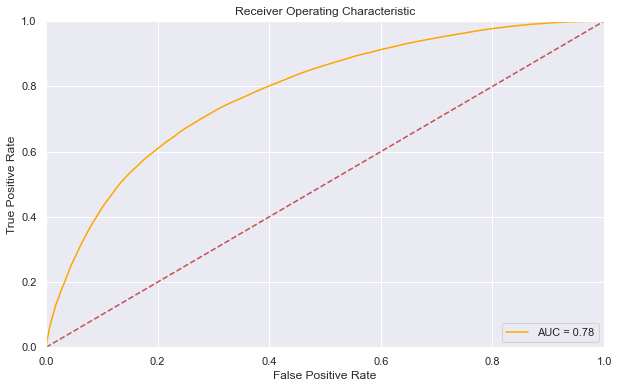

In [102]:
plot_auc((y_test == 1), probabilities)

<AxesSubplot:xlabel='Importance'>

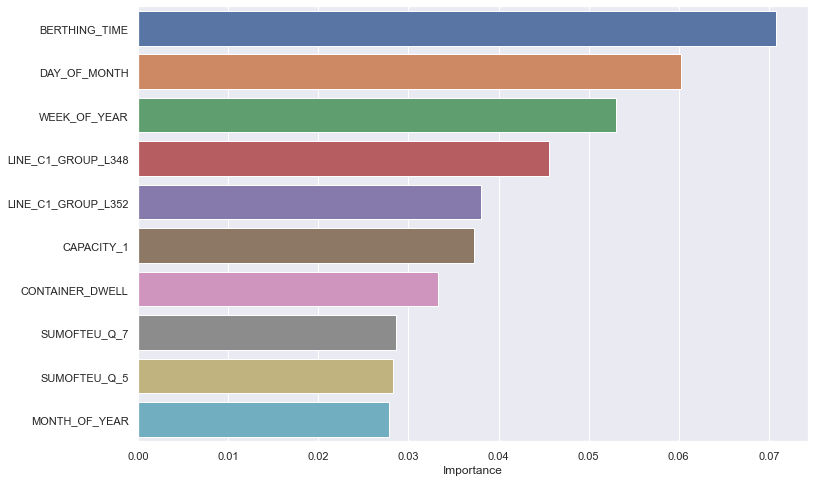

In [103]:
# Plot top 10 important features from random forest classifier
feature_imp = pd.DataFrame(rf_clf.feature_importances_, index=X_train.columns,columns=['Importance']).sort_values('Importance',ascending=False)
feature_imp = feature_imp.head(10)
feature_imp

plt.figure(figsize=(12,8))
sns.barplot(x=feature_imp['Importance'], y=feature_imp.index)

In [104]:
new_list = ['LINE_C1_GROUP_L348','CONTAINER_DWELL','SUMOFTEU_Q_5','SUMOFTEU_Q_7','BERTHING_TIME',
            'CAPACITY_1','LINE_C1_GROUP_L352','DAY_OF_MONTH','WEEK_OF_YEAR','MONTH_OF_YEAR']

In [105]:
X2 = X[new_list]

In [106]:
# Train-split 
X_train = X2[:200247] #70% train
X_test = X2[-85821:]  #30% test
y_train = y[:200247] #70% train
y_test = y[-85821:]  #30% test

In [107]:
# Set up params
model_params = {
    # randomly sample numbers from 4 to 204 estimators
    'n_estimators': randint(4,200),
    # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    'min_samples_split': uniform(0.01, 0.199)
}

In [108]:
%%time

# Create random forest classifier model
rf_model = RandomForestClassifier()

# Set up random search meta-estimator
# This will train 5 models over 5 folds of cross validation (25 models total)
clf = RandomizedSearchCV(rf_model, model_params, n_iter=5, cv=5, random_state=42)

# Train the random search meta-estimator on resampled train data to find the best model out of 5 candidates
rf_clf = clf.fit(X_train, y_train)

# Print winning set of hyperparameters
print(rf_clf.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.2517613506094637, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 0.20301206058023688, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 161, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Wall time: 8min 39s


In [109]:
#-------------------------------- Model testing ---------------------------------#

# Predict for X_test data set using the fitted model
y_pred_rf_clf = rf_clf.predict(X_test)

In [110]:
#-------------------------------- Model evaluation ---------------------------------#
# Evaluate model accuracy using fitted y value and actual y_test
# Evaluation metrics to be used - eg. Precision, Recall, confusion matrix, ROC 

# Probabilities prediction on test set
probabilities = rf_clf.predict_proba(X_test)

In [111]:
# Display AUC and confusion matrix
print_metrics2((y_test == 1), probabilities, 0.5)

                 Confusion matrix
                 Actual negative    Actual positive
Score negative     31025              7390
Score positive     29487             17919

Accuracy        0.57
AUC             0.68
Macro precision 0.61
Macro recall    0.59
 
           Negative     Positive
Num case    38415         47406
Precision    0.51          0.71
Recall       0.81          0.38
F1           0.63          0.49


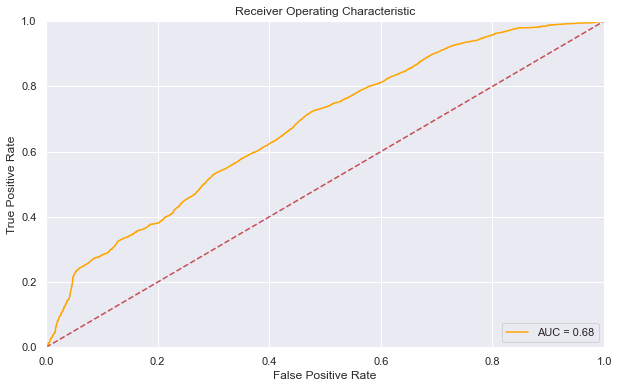

In [112]:
plot_auc((y_test == 1), probabilities)

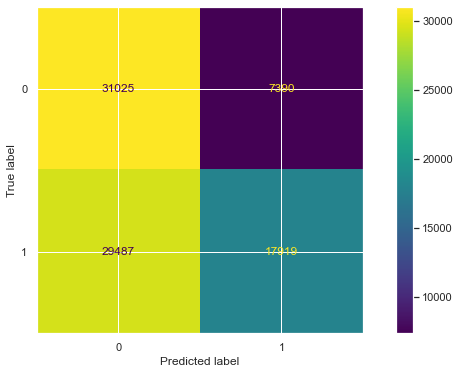

In [113]:
get_count_confusion_metrics(rf_clf,X_test,y_test)

## 6. Lift Chart for vessel dwell <a class="anchor" id="6.LiftChartforvesseldwell"></a>

1.2817373566977444

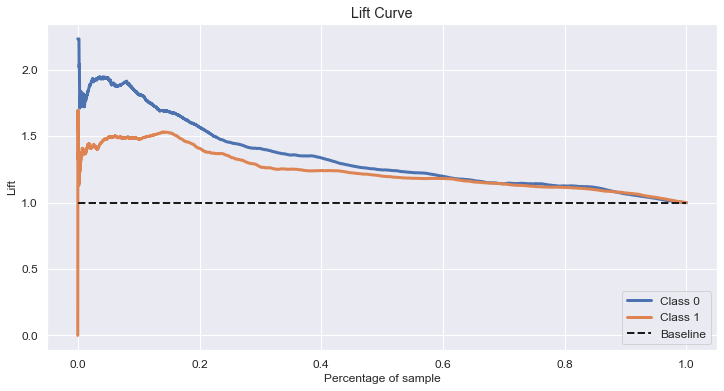

In [114]:
# Plot the lift chart from the best classifier model

# Probabilities prediction on test set data
y_test_probs = rf_clf.predict_proba(X_test)

skplt.metrics.plot_lift_curve(y_test,y_test_probs,figsize=(12, 6))

lift_score(y_test,y_pred_rf_clf)

In [118]:
def calc_cumulative_gains(df: pd.DataFrame, actual_col: str, predicted_col:str, probability_col:str):

    df.sort_values(by=probability_col, ascending=False, inplace=True)

    subset = df

    rows = []
    for group in np.array_split(subset, 10):
        
        score= sum(group[actual_col].tolist())
        
        rows.append({'NumCases': len(group), 'ActualDelay': score})

    lift = pd.DataFrame(rows)

    #Cumulative Gains Calculation
    lift['CumActualDelay'] = lift['ActualDelay'].cumsum()
    lift['PercCorrect'] = lift.apply(
        lambda x: (100 / lift['ActualDelay'].sum()) * x['CumActualDelay'], axis=1)
    lift['CumNumCase'] = lift['NumCases'].cumsum()
    lift['AvgCase'] = lift['ActualDelay'].sum() / len(lift)
    lift['CumAvgCase'] = lift['AvgCase'].cumsum()
    lift['PercAvgCase'] = lift['CumAvgCase'].apply(
        lambda x: (100 / lift['ActualDelay'].sum()) * x)

    #Lift Chart
    lift['BaseLine'] = 1
    lift['PercWithModel'] = lift['PercCorrect'] / lift['PercAvgCase']

    return lift

def plot_lift_chart(lift: pd.DataFrame):
        plt.figure()
        plt.plot(lift['BaseLine'], 'r-', label='\'response rate\' with no model')
        plt.plot(lift['PercWithModel'], 'g-', label='\'response rate\' with using model')
        plt.legend()
        plt.show()

In [119]:
d = {'Above 23hr': y_test, 'pred_probs': y_test_probs[:,1],"predicted" : y_pred_rf_clf}
df = pd.DataFrame(data=d)
df

Above 23hr  pred_probs  predicted
ARRIVAL_WEEK                                   
2019-08                1    0.482982          0
2019-08                0    0.528962          1
2019-08                1    0.645005          1
2019-08                0    0.465088          0
2019-08                1    0.486141          0
...                  ...         ...        ...
2019-52                1    0.478948          0
2019-52                1    0.472615          0
2019-52                0    0.461457          0
2019-52                1    0.459771          0
2019-52                0    0.499779          0

[85821 rows x 3 columns]

In [120]:
lift =calc_cumulative_gains(df,"Above 23hr","predicted","pred_probs")
lift

NumCases  ActualDelay  CumActualDelay  PercCorrect  CumNumCase  AvgCase  \
0      8583         7018            7018    14.804033        8583   4740.6   
1      8582         6346           13364    28.190524       17165   4740.6   
2      8582         4699           18063    38.102772       25747   4740.6   
3      8582         5490           23553    49.683584       34329   4740.6   
4      8582         4891           28444    60.000844       42911   4740.6   
5      8582         5193           33637    70.955153       51493   4740.6   
6      8582         4252           37889    79.924482       60075   4740.6   
7      8582         4415           42304    89.237649       68657   4740.6   
8      8582         3504           45808    96.629119       77239   4740.6   
9      8582         1598           47406   100.000000       85821   4740.6   

   CumAvgCase  PercAvgCase  BaseLine  PercWithModel  
0      4740.6         10.0         1       1.480403  
1      9481.2         20.0         1       1.409526  
2     14221.8         30.0         1       1.270092  
3     18962.4         40.0         1       1.242090  
4     23703.0         50.0         1       1.200017  
5     28443.6         60.0         1       1.182586  
6     33184.2         70.0         1       1.141778  
7     37924.8         80.0         1       1.115471  
8     42665.4         90.0         1       1.073657  
9     47406.0        100.0         1       1.000000

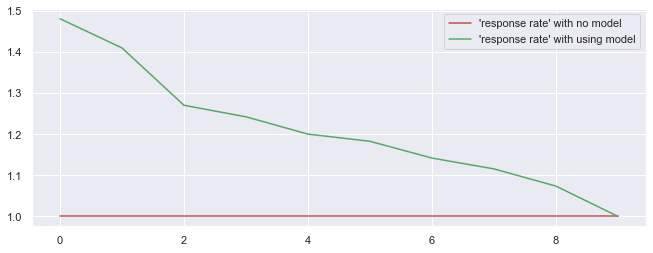

In [121]:
plot_lift_chart(lift)

### Classifier Model for container dwell

#### Pre-processing data for modeling

Using disc_df discharge dataset for modeling

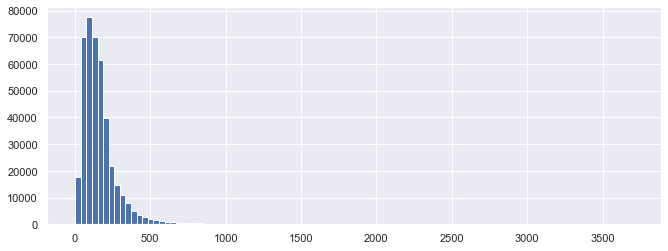

In [129]:
# Check distribution of container dwell
plt.hist(data=disc_df, x='CONTAINER_DWELL', bins=100);

In [136]:
# Create label base on 75 percentile value @ 199h
disc_df['CONTAINER_DWELL_STATUS'] = np.where(disc_df['CONTAINER_DWELL'] > 199, 'Above 199h', 'Below 199h')

<ipython-input-136-9bbfbc1915b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disc_df['CONTAINER_DWELL_STATUS'] = np.where(disc_df['CONTAINER_DWELL'] > 199, 'Above 199h', 'Below 199h')


In [138]:
disc_df

EVENT_C CNTR_STATUS_C DISC_PORT1_C LOAD_PORT_C ABBR_VESSEL_M1  \
ARRIVAL_DATE                                                                 
2017-01-01      DISC             F        BEANR       VNVUT         V10472   
2017-01-01      DISC             F        GBFXT       MYPEN         V11985   
2017-01-01      DISC             F        KRPUS       IDSUB         V11682   
2017-01-01      DISC             F        PHGES       USNYC         V11794   
2017-01-01      DISC             F        USNYC       CNNKG         V12345   
...              ...           ...          ...         ...            ...   
2019-12-31      DISC             F        USJAX       IDSRG         V11850   
2019-12-31      DISC             F        FRFOS       IDSRG         V11850   
2019-12-31      DISC             F        VNHPH       KEMBA         V12828   
2019-12-31      DISC             F        AUMEL       SIKOP         V11245   
2019-12-31      DISC             F        CIABJ       IDJKT         V10365   

                            BTR1                ATD1                ATU1  \
ARRIVAL_DATE                                                               
2017-01-01   2017-01-01 21:02:00 2017-01-01 22:57:00 2017-01-03 02:11:00   
2017-01-01   2017-01-01 18:02:00 2017-01-01 18:47:00 2017-01-02 09:49:00   
2017-01-01   2017-01-02 01:04:00 2017-01-01 20:02:00 2017-01-02 14:44:00   
2017-01-01   2017-01-01 14:02:00 2017-01-01 16:37:00 2017-01-02 14:34:00   
2017-01-01   2017-01-01 07:47:00 2017-01-01 09:37:00 2017-01-02 10:04:00   
...                          ...                 ...                 ...   
2019-12-31   2019-12-31 00:58:00 2019-12-31 01:13:00 2020-01-01 00:22:00   
2019-12-31   2019-12-31 00:58:00 2019-12-31 01:13:00 2020-01-01 00:22:00   
2019-12-31   2019-12-31 02:58:00 2019-12-31 04:13:00 2019-12-31 16:33:00   
2019-12-31   2019-12-31 14:58:00 2019-12-31 22:53:00 2020-01-02 09:19:00   
2019-12-31   2019-12-31 00:58:00 2019-12-31 14:48:00 2020-01-01 09:12:00   

             LINE_C1_GROUP SERVICE_C1 DIRECTION_C1  CAPACITY_1 ABBR_VESSEL_M2  \
ARRIVAL_DATE                                                                    
2017-01-01            L391      S7434            W      9000.0         V11806   
2017-01-01            L376      S7611            W      1000.0         V12361   
2017-01-01            L390      S7657            E      4000.0         V12013   
2017-01-01            L348      S7595            W      9000.0         V11040   
2017-01-01            L367      S7447            W     13000.0         V10437   
...                    ...        ...          ...         ...            ...   
2019-12-31            L376      S7429            S      2000.0         V12862   
2019-12-31            L376      S7429            S      2000.0         V11442   
2019-12-31            L402      S7410            E      3000.0         V10293   
2019-12-31            L390      S7356            E     15000.0         V11211   
2019-12-31            L341      S7507            E      5000.0         V12625   

                            BTR2                ATD2                ATU2  \
ARRIVAL_DATE                                                               
2017-01-01   2017-01-04 13:38:00 2017-01-04 15:43:00 2017-01-05 16:10:00   
2017-01-01   2017-01-03 22:06:00 2017-01-03 23:46:00 2017-01-04 20:28:00   
2017-01-01   2017-01-04 07:38:00 2017-01-04 09:08:00 2017-01-05 20:40:00   
2017-01-01   2017-01-09 13:18:00 2017-01-09 19:33:00 2017-01-10 05:45:00   
2017-01-01   2017-01-06 21:12:00 2017-01-06 22:02:00 2017-01-07 18:44:00   
...                          ...                 ...                 ...   
2019-12-31   2020-01-17 13:09:00 2020-01-17 15:04:00 2020-01-18 06:45:00   
2019-12-31   2020-01-11 21:52:00 2020-01-11 22:52:00 2020-01-13 11:01:00   
2019-12-31   2020-01-03 17:06:00 2020-01-03 18:31:00 2020-01-04 20:43:00   
2019-12-31   2020-01-13 11:56:00 2020-01-14 00:58:00 2020-01-15 07:00:00   
2019-12-31   2020-01-09 21:18:00 2020-01-10

In [139]:
# Prepare drop list
drop_list2 = ['EVENT_C', 'CNTR_STATUS_C','ABBR_VESSEL_M1','BTR1','ATD1', 'ATU1', 'SERVICE_C1','ABBR_VESSEL_M2','BTR2', 'ATD2', 
             'ATU2','LINE_C2_GROUP', 'SERVICE_C2', 'DIRECTION_C2', 'CAPACITY_2','DERIVED_CNTR_PURP_C','OPR_GROUP_C', 
             'SUMOFBOX_Q','QUARTER_OF_YEAR', 'YEAR', 'VESSEL_TYPE_M2','SUMOFBOX_Q_2', 
             'SUMOFBOX_Q_3','SUMOFBOX_Q_5', 'SUMOFBOX_Q_7','CONTAINER_DWELL']

In [140]:
# Drop variables
teu_dwell_df = disc_df.drop(drop_list2, axis = 1)

In [141]:
teu_dwell_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 415093 entries, 2017-01-01 to 2019-12-31
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   DISC_PORT1_C                415093 non-null  object 
 1   LOAD_PORT_C                 415093 non-null  object 
 2   LINE_C1_GROUP               415093 non-null  object 
 3   DIRECTION_C1                415093 non-null  object 
 4   CAPACITY_1                  415093 non-null  float64
 5   SUMOFTEU_Q                  415093 non-null  float64
 6   ARRIVAL_WEEK                415093 non-null  object 
 7   ARRIVAL_MONTH               415093 non-null  object 
 8   DAY_OF_MONTH                415093 non-null  int64  
 9   WEEK_OF_YEAR                415093 non-null  int64  
 10  MONTH_OF_YEAR               415093 non-null  int64  
 11  DISC_COUNTRY                415093 non-null  object 
 12  LOAD_COUNTRY                415093 non-null  object 
 13

In [142]:
# Select features

cat_col2 = ['DISC_PORT1_C', 'LOAD_PORT_C','LINE_C1_GROUP','DIRECTION_C1','ARRIVAL_MONTH','ARRIVAL_WEEK', 
           'DISC_COUNTRY','LOAD_COUNTRY','VESSEL_TYPE_M1','CONTAINER_LOAD_VESSEL_TYPE','CONTAINER_DWELL_STATUS']

num_col2 = ['CAPACITY_1', 'SUMOFTEU_Q','DAY_OF_MONTH', 'WEEK_OF_YEAR','MONTH_OF_YEAR','SUMOFTEU_Q_2', 
           'SUMOFTEU_Q_3','SUMOFTEU_Q_5', 'SUMOFTEU_Q_7', 'BERTHING_TIME', 'VESSEL_DWELL']

In [145]:
# Check distribution for target label
teu_dwell_df['CONTAINER_DWELL_STATUS'].value_counts() / len(teu_dwell_df)

Below 199h    0.750793
Above 199h    0.249207
Name: CONTAINER_DWELL_STATUS, dtype: float64

In [148]:
# Define dataset
class_0 = teu_dwell_df.drop('CONTAINER_DWELL_STATUS', axis = 1)
class_1 = teu_dwell_df.CONTAINER_DWELL_STATUS     

# Define random oversampling strategy
ros = RandomOverSampler(random_state=42)
class_0_ros, class_1_ros = ros.fit_resample(class_0 , class_1)

# Merge data as rs (resampled dataframe)
rs_df2 = pd.concat([class_0_ros, class_1_ros], axis=1)

# Check distribution of class after resampling
rs_df2['CONTAINER_DWELL_STATUS'].value_counts()/len(rs_df2['CONTAINER_DWELL_STATUS'])

Below 199h    0.5
Above 199h    0.5
Name: CONTAINER_DWELL_STATUS, dtype: float64

In [150]:
# Convert 'CONTAINER_DWELL_STATUS' into Above 23h=1, Below 23h=0 
rs_df2['CONTAINER_DWELL_STATUS'] = np.where(rs_df2['CONTAINER_DWELL_STATUS'] == 'Above 199h', 1, 0)

In [152]:
rs_df2 = rs_df2.sort_values('ARRIVAL_WEEK')
rs_df2= rs_df2.set_index('ARRIVAL_WEEK')

In [154]:
%%time
# Define X and y 
X = rs_df2.drop('CONTAINER_DWELL_STATUS', axis = 1) 
y = rs_df2.CONTAINER_DWELL_STATUS 

# Scaling 
sc = StandardScaler()
X_scaled = sc.fit_transform(X[num_col2])
X_scaled = pd.DataFrame(X_scaled, columns = num_col2)

# Get dummy 
X_dummy = pd.get_dummies(X)
X_dummy.update(X_scaled)

X = X_dummy

Wall time: 1min 31s


In [157]:
X

CAPACITY_1  SUMOFTEU_Q  DAY_OF_MONTH  WEEK_OF_YEAR  \
ARRIVAL_WEEK                                                       
2017-01           9000.0        10.0             1            52   
2017-01            900.0         9.0             7             1   
2017-01           4000.0         5.0             7             1   
2017-01           4000.0         1.0             7             1   
2017-01           6000.0        10.0             7             1   
...                  ...         ...           ...           ...   
2019-52           9000.0         2.0            30             1   
2019-52          19000.0         4.0            30             1   
2019-52           9000.0         1.0            30             1   
2019-52          13000.0         2.0            30             1   
2019-52           7000.0         1.0            30             1   

              MONTH_OF_YEAR  SUMOFTEU_Q_2  SUMOFTEU_Q_3  SUMOFTEU_Q_5  \
ARRIVAL_WEEK                                                            
2017-01                   1           8.0      5.666667           5.6   
2017-01                   1           7.0      7.000000           9.8   
2017-01                   1           4.0     12.333333           8.0   
2017-01                   1           1.5      3.666667           3.0   
2017-01                   1           6.0     11.333333          10.0   
...                     ...           ...           ...           ...   
2019-52                  12          39.0     26.333333          18.0   
2019-52                  12           2.5      3.000000           5.2   
2019-52                  12           2.5      6.333333          13.4   
2019-52                  12           2.0      5.333333           4.0   
2019-52                  12           2.5      2.333333           8.2   

              SUMOFTEU_Q_7  BERTHING_TIME  VESSEL_DWELL  DISC_PORT1_C_AEAUH  \
ARRIVAL_WEEK                                                                  
2017-01          16.428571       1.916667     27.233333                   0   
2017-01          16.857143      -0.250000     16.533333                   0   
2017-01           6.571429       1.750000     17.116667                   0   
2017-01           2.571429       1.750000     17.116667                   0   
2017-01           8.571429      -1.666667     16.450000                   0   
...                    ...            ...           ...                 ...   
2019-52          18.714286       3.500000     14.466667                   0   
2019-52           5.000000       6.250000     31.300000                   0   
2019-52          10.714286       1.916667     25.133333                   0   
2019-52           4.571429       6.500000     33.866667                   0   
2019-52           6.857143       0.666667     34.050000                   0   

              DISC_PORT1_C_AEDXB  DISC_PORT1_C_AEJE1  DISC_PORT1_C_AEJE9  \
ARRIVAL_WEEK                                                               
2017-01                        0                   0                   0   
2017-01                        0                   0                   0   
2017-01                        0                   0                   0   
2017-01                        0                   0                   0   
2017-01                        0                   0                   0   
...                          ...                 ...                 ...   
2019-52                        0                   0                   0   
2019-52                        0                   0                   0   
2019-52                        0                   0                   0   
2019-52                        0                   0                   0   
2019-52                        0                   0                   0   

              DISC_PORT1_C_AEJEA  DISC_PORT1_C_AEJT1  DISC_PORT1_C_AEKHL  \
ARRIVAL_WEEK                                                               
2017-01   

In [158]:
# Train-split 
X_train = X[:436308] #70% train
X_test = X[-186990:]  #30% test
y_train = y[:436308] #70% train
y_test = y[-186990:]  #30% test

In [159]:
%%time
#---------------------- Model training with resampled data-----------------------#

# Train random forest classifier model on training data set
# Initialize randomforest classifier

rf_clf2 = RandomForestClassifier(random_state = 42)

# Fit the training data
rf_clf2.fit(X_train, y_train)

Wall time: 16min 44s


RandomForestClassifier(random_state=42)

In [160]:
#-------------------------------- Model testing ---------------------------------#

# Predict for X_test data set using the fitted model
y_pred_rf_clf2 = rf_clf2.predict(X_test)

In [161]:
#-------------------------------- Model evaluation ---------------------------------#
# Evaluate model accuracy using fitted y value and actual y_test
# Evaluation metrics to be used - eg. Precision, Recall, confusion matrix, ROC 

# Probabilities prediction on test set
probabilities = rf_clf2.predict_proba(X_test)

In [162]:
# Display AUC and confusion matrix
print_metrics2((y_test == 1), probabilities, 0.5)

                 Confusion matrix
                 Actual negative    Actual positive
Score negative     89266              5213
Score positive     74498             18013

Accuracy        0.57
AUC             0.68
Macro precision 0.66
Macro recall    0.57
 
           Negative     Positive
Num case    94479         92511
Precision    0.55          0.78
Recall       0.94          0.19
F1           0.69          0.31


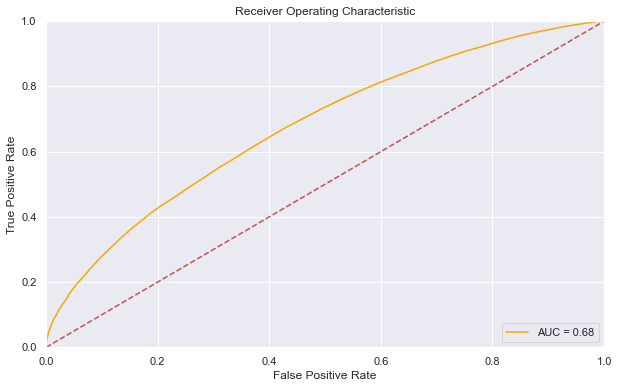

In [163]:
plot_auc((y_test == 1), probabilities)

<AxesSubplot:xlabel='Importance'>

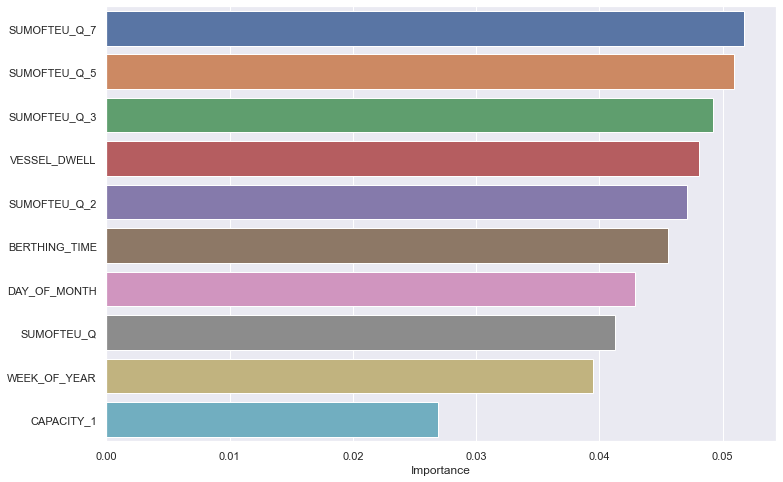

In [164]:
# Plot top 10 important features from random forest classifier
feature_imp = pd.DataFrame(rf_clf2.feature_importances_, index=X_train.columns,columns=['Importance']).sort_values('Importance',ascending=False)
feature_imp = feature_imp.head(10)
feature_imp

plt.figure(figsize=(12,8))
sns.barplot(x=feature_imp['Importance'], y=feature_imp.index)

In [165]:
new_list2 = ['VESSEL_DWELL','SUMOFTEU_Q','SUMOFTEU_Q_2','SUMOFTEU_Q_3','SUMOFTEU_Q_5','SUMOFTEU_Q_7','BERTHING_TIME',
            'CAPACITY_1','DAY_OF_MONTH','WEEK_OF_YEAR']

In [166]:
X2 = X[new_list2]

In [168]:
# Train-split 
X_train = X2[:436308] #70% train
X_test = X2[-186990:]  #30% test
y_train = y[:436308] #70% train
y_test = y[-186990:]  #30% test

In [170]:
%%time

# Create random forest classifier model
rf_model2 = RandomForestClassifier()

# Set up random search meta-estimator
# This will train 5 models over 5 folds of cross validation (25 models total)
clf2 = RandomizedSearchCV(rf_model2, model_params, n_iter=5, cv=5, random_state=42)

# Train the random search meta-estimator on resampled train data to find the best model out of 5 candidates
rf_clf2 = clf2.fit(X_train, y_train)

# Print winning set of hyperparameters
print(rf_clf2.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.26338715088042397, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 0.021558638821471694, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 91, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Wall time: 32min 33s


In [171]:
#-------------------------------- Model testing ---------------------------------#

# Predict for X_test data set using the fitted model
y_pred_rf_clf2 = rf_clf2.predict(X_test)

In [172]:
#-------------------------------- Model evaluation ---------------------------------#
# Evaluate model accuracy using fitted y value and actual y_test
# Evaluation metrics to be used - eg. Precision, Recall, confusion matrix, ROC 

# Probabilities prediction on test set
probabilities = rf_clf2.predict_proba(X_test)

In [175]:
# Display AUC and confusion matrix
print_metrics2((y_test == 1), probabilities, 0.5)

                 Confusion matrix
                 Actual negative    Actual positive
Score negative     46346             48133
Score positive     40614             51897

Accuracy        0.53
AUC             0.53
Macro precision 0.53
Macro recall    0.53
 
           Negative     Positive
Num case    94479         92511
Precision    0.53          0.52
Recall       0.49          0.56
F1           0.51          0.54


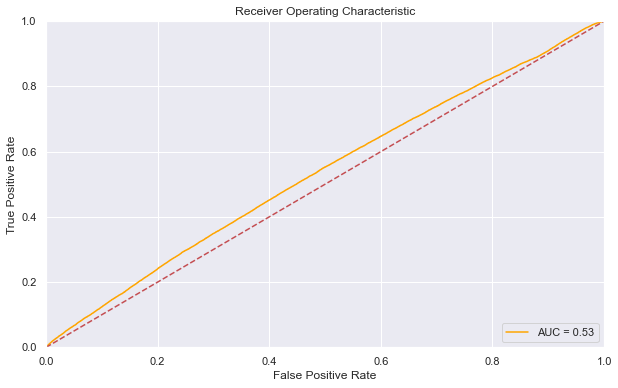

In [173]:
plot_auc((y_test == 1), probabilities)

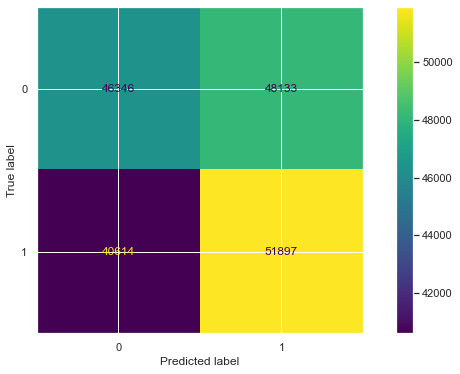

In [174]:
get_count_confusion_metrics(rf_clf2,X_test,y_test)

## 7. Lift Chart for container dwell <a class="anchor" id="7.LiftChartforcontainerdwell"></a>

In [179]:
d = {'Above 199h': y_test, 'pred_probs': probabilities[:,1],"predicted" : y_pred_rf_clf2}
df = pd.DataFrame(data=d)
df

Above 199h  pred_probs  predicted
ARRIVAL_WEEK                                   
2019-06                1    0.527143          1
2019-06                1    0.535398          1
2019-06                0    0.536120          1
2019-06                1    0.517056          1
2019-06                1    0.540687          1
...                  ...         ...        ...
2019-52                1    0.527771          1
2019-52                0    0.508302          1
2019-52                0    0.494307          0
2019-52                1    0.501085          1
2019-52                1    0.493842          0

[186990 rows x 3 columns]

In [180]:
lift2 =calc_cumulative_gains(df,"Above 199h","predicted","pred_probs")
lift2

NumCases  ActualDelay  CumActualDelay  PercCorrect  CumNumCase  AvgCase  \
0     18699        10291           10291    11.124083       18699   9251.1   
1     18699         9934           20225    21.862265       37398   9251.1   
2     18699         9766           29991    32.418847       56097   9251.1   
3     18699         9366           39357    42.543049       74796   9251.1   
4     18699         9325           48682    52.622931       93495   9251.1   
5     18699         9094           57776    62.453114      112194   9251.1   
6     18699         8866           66642    72.036839      130893   9251.1   
7     18699         8729           75371    81.472474      149592   9251.1   
8     18699         8324           83695    90.470322      168291   9251.1   
9     18699         8816           92511   100.000000      186990   9251.1   

   CumAvgCase  PercAvgCase  BaseLine  PercWithModel  
0      9251.1         10.0         1       1.112408  
1     18502.2         20.0         1       1.093113  
2     27753.3         30.0         1       1.080628  
3     37004.4         40.0         1       1.063576  
4     46255.5         50.0         1       1.052459  
5     55506.6         60.0         1       1.040885  
6     64757.7         70.0         1       1.029098  
7     74008.8         80.0         1       1.018406  
8     83259.9         90.0         1       1.005226  
9     92511.0        100.0         1       1.000000

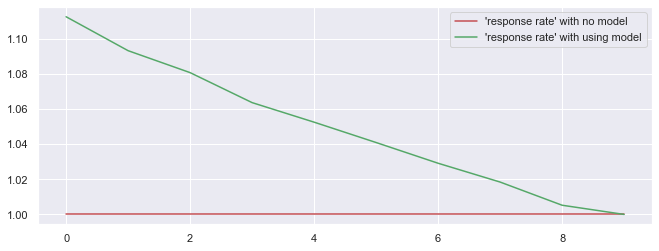

In [181]:
plot_lift_chart(lift2)